In [ ]:
import trainpdir as tpml
import trainq as tq
import sklearn
import scipy.sparse
import numpy as np
import json
import graph
import random
import os, time, collections, shutil
import scipy.sparse as sp
from scipy import sparse
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
from numpy import genfromtxt
import sys
import warnings
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
np.random.seed(1337)
from keras.layers import UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils.np_utils import to_categorical   
from keras.models import load_model
from sklearn.metrics import classification_report
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

True

In [ ]:
TrainLength = 171 #416#171 #
TrainCount = 171
ValCount = 120
TestCount =132 #208  #132 #
row= 224
col = 224
ValCountGraph = 1
valrow = 2120
valcol = 2555
test1row = 2685 #3485 #2685 #
test1col =2460  #2875 #2460 #
CT= 'CT_DS_Factor4/'
Data= 'ChunkData/'
notConvergence = 1
threshold = 0.001
ave_accuracy_old = 0

TrainID = np.array(range(0,TrainLength))
random.Random(2).shuffle(TrainID)
TrainID = TrainID[0:TrainCount]

root_path =" " #add your data root path here
train_folder_path = root_path + "Train/Dataset1/"
validation_folder_path = root_path + "Validation/Dataset1/"
test_folder_path = root_path + "Test/Dataset1/"

#GNN Parameter
params = dict()
params['num_epochs']     =150 #args.num_epochs
params['batch_size']     = 1 #args.batch_size
params['filter']         ='chebyshev5' #args.filter
params['brelu']          = 'b1relu'

params['F_0']            = 2 # Number of graph input features.
params['F_1']            = 2  # Number of graph output features.
params['M_0']            = 1000 # Number of graph nodes.  

params['classnum']            = 2 # Number of output class.  
params['F']              =32 # Number of graph convolutional filters.

params['K']              = 2

params['regularization'] = 1e-3
params['dropout']        = 1
params['learning_rate']  = 1e-4
params['decay_rate']     = 0.99
params['momentum']       = 0.9

params['eval_frequency'] = 70
params['dir_name'] = 'C:/tflow2/Scripts/wenchong/NIPS2020/'

In [ ]:
def laplacian(W):
    d = W.sum(axis = 1)
    d[d==0]=1
    d = 1 / d
    D = sp.diags(d.A.squeeze(), 0)
    L = D*W
    return L 

def findclass(predicted):
    newpre = -1*np.zeros((predicted.shape[0],predicted.shape[1]))
    for i in range(predicted.shape[0]):
        for j in range(predicted.shape[1]):
            if predicted[i,j,0] > predicted[i, j, 1]:
                newpre[i,j] = 0
            else:
                newpre[i,j] = 1
    return newpre

def load_data():
    
    
    train_features = []
    #train_features_temp = []
    train_labels = []
    train_features_graph = []
    train_labels_graph = []
    L = []
    L1=[]
    L2=[]
    DS = []
    US = []
    
    for i in range(TrainCount): 
        feature = np.load(train_folder_path+'ChunkData/'+str(i)+"trainFeaturesWithElv.npy")
        feature.shape = row,col,4
        label = np.load(train_folder_path+'ChunkData/'+str(i)+"trainLabel.npy")
        label.shape = row,col,1
        train_features.append(feature)
        train_labels.append(label)
        
        graphfeature = np.load(train_folder_path+'ChunkData/'+str(i)+"trainFeaturesWithElv.npy")
        graphfeature.shape = row,col,4
        graphfeature.shape = row*col,4
        train_features_graph.append(graphfeature)
        
        label = np.reshape(label, (row*col, 1))
        label = to_categorical(label, num_classes = 2)
        train_labels_graph.append(label)

        sm_row = []
        sm_col = []
        sm_data = []
        file= open(train_folder_path+'CT_DS_Factor4_Collapse/'+str(i)+'traincollapseList1.txt', "r")
        for line in file:
            linelist = line.split(",")
            collapselist = [int(ll) for ll in linelist] 
            nodeId = collapselist.pop(0)
            for c in collapselist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        Dmat = (sparse.csr_matrix((sm_data,(sm_row,sm_col))))
        Umat = Dmat.transpose()
        Dmat = preprocessing.normalize(Dmat,norm='l1',axis=1)
        DS.append(Dmat)
        US.append(Umat)
        sm_row = []
        sm_col = []
        sm_data = []
        file= open(train_folder_path+'CT_DS_Factor4_Collapse/'+str(i)+'traincollapseTree1'+'.txt', "r")
        lineCounter = 0
        for line in file:
            lineCounter +=1
            linelist = line.split(",")
            childlist = [int(i) for i in linelist] 
            nodeId = childlist.pop(0)
            for c in childlist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        adj = sparse.csr_matrix((sm_data,(sm_row,sm_col)), shape=(lineCounter, lineCounter))
        adj2 = sparse.csr_matrix.transpose(adj)
        L1.append(adj)
        L2.append(adj2)
    
    
    for i in range(0,ValCount):
        feature = np.load(validation_folder_path+'ChunkData/'+str(i)+"validationFeaturesWithElv.npy")
        feature.shape = row,col,4
        label = np.load(validation_folder_path+'ChunkData/'+str(i)+"validationLabel.npy")

        label.shape = row,col,1
        train_features.append(feature)
        train_labels.append(label)
        
    for i in range(0, ValCountGraph):
        feature = np.load(validation_folder_path+'ImageData/'+str(i)+"validationFeaturesWithElv.npy")
        feature.shape = valrow,valcol,4
        feature.shape = valrow*valcol,4
        train_features_graph.append(feature)
        
        label = np.load(validation_folder_path+'ImageData/'+str(i)+"validationLabel.npy")
        label.shape = valrow,valcol,1
        label = np.reshape(label, (valrow*valcol, 1))
        label = to_categorical(label, num_classes = 2)
        train_labels_graph.append(label)
        
        sm_row = []
        sm_col = []
        sm_data = []
        file= open(validation_folder_path+'CT_DS_Factor4_whole_Collapse/'+str(i)+'validationcollapseList1.txt', "r")
        for line in file:
            linelist = line.split(",")
            collapselist = [int(ll) for ll in linelist] 
            nodeId = collapselist.pop(0)
            for c in collapselist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        Dmat = (sparse.csr_matrix((sm_data,(sm_row,sm_col))))
        Umat = Dmat.transpose()
        Dmat = preprocessing.normalize(Dmat,norm='l1',axis=1)

        DS.append(Dmat)
        US.append(Umat)
    
        sm_row = []
        sm_col = []
        sm_data = []
        file= open(validation_folder_path+'CT_DS_Factor4_whole_Collapse/'+str(i)+'validationcollapseTree1'+'.txt', "r")
        lineCounter = 0
        for line in file:
            lineCounter +=1
            linelist = line.split(",")
            childlist = [int(i) for i in linelist] 
            nodeId = childlist.pop(0)
            for c in childlist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        adj = sparse.csr_matrix((sm_data,(sm_row,sm_col)), shape=(lineCounter, lineCounter))
        adj2 = sparse.csr_matrix.transpose(adj)
        L1.append(adj)
        L2.append(adj2)        
   
    for i in range(0,TestCount):
        feature = np.load(test_folder_path+'ChunkData/'+str(i)+"testFeaturesWithElv.npy")
        feature.shape = row,col,4
        label = np.load(test_folder_path+'ChunkData/'+str(i)+"testLabel.npy")
        label.shape = row,col,1
        train_features.append(feature)
        train_labels.append(label)
        
    for i in range(0,ValCountGraph):
        feature = np.load(test_folder_path+'ImageData/'+str(i)+"testFeaturesWithElv.npy")
        feature.shape = test1row,test1col,4
        feature.shape = test1row*test1col,4
        train_features_graph.append(feature)
        
        label = np.load(test_folder_path+'ImageData/'+str(i)+"testLabel.npy")
        label.shape = test1row,test1col,1
        label = np.reshape(label, (test1row*test1col, 1))
        label = to_categorical(label, num_classes = 2)
        train_labels_graph.append(label)
        
        
        sm_row = []
        sm_col = []
        sm_data = []
        file= open(test_folder_path+'CT_DS_Factor4_whole_Collapse/'+str(i)+'testcollapseList1.txt', "r")
        for line in file:
            linelist = line.split(",")
            collapselist = [int(ll) for ll in linelist] 
            nodeId = collapselist.pop(0)
            for c in collapselist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        Dmat = (sparse.csr_matrix((sm_data,(sm_row,sm_col))))
        Umat = Dmat.transpose()
        Dmat = preprocessing.normalize(Dmat,norm='l1',axis=1)
        DS.append(Dmat)
        US.append(Umat)
        
        sm_row = []
        sm_col = []
        sm_data = []
        file= open(test_folder_path+'CT_DS_Factor4_whole_Collapse/'+str(i)+'testcollapseTree1'+'.txt', "r")
        lineCounter = 0
        for line in file:
            lineCounter +=1
            linelist = line.split(",")
            childlist = [int(i) for i in linelist] 
            nodeId = childlist.pop(0)
            for c in childlist:
                sm_row.append(nodeId)
                sm_col.append(c)
                sm_data.append(1)
        file.close()
        adj = sparse.csr_matrix((sm_data,(sm_row,sm_col)), shape=(lineCounter, lineCounter))
        adj2 = sparse.csr_matrix.transpose(adj)
        L1.append(adj)
        L2.append(adj2)
        
    
    L1 = map(lambda x:x.astype('float32'), L1)
    L1 = [laplacian(a) for a in L1]
    
    L2 = map(lambda x:x.astype('float32'), L2)
    L2 = [laplacian(a) for a in L2]

    train_features = np.array(train_features)
    train_features_graph = np.array(train_features_graph)
    train_labels = np.array(train_labels)
    train_labels_graph = np.array(train_labels_graph)
    val_idx = [i for i in range (TrainCount, TrainCount + ValCount)]
    test_idx = [i for i in range (TrainCount + ValCount, TrainCount + ValCount + TestCount)]
    val_idx = np.array(val_idx)
    test_idx = np.array(test_idx)
    return train_features, train_features_graph, train_labels, train_labels_graph, val_idx, test_idx,L1,L2, DS, US

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_data_format() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv

def plot_history(history,location):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' not in s]
    val_dice_list = [s for s in history.history.keys() if 'dice' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Dice Coefficient
    plt.figure(2)
    for l in dice_list:
        plt.plot(epochs, history.history[l], 'b', label='Training Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_dice_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation Dice Coefficient (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    ## Accuracy
    fig=plt.figure(3)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    fig.savefig(location, dpi=fig.dpi)


IMG_WIDTH = 224
IMG_HEIGHT = 224

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 4
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 2

def UNET(dropout_val=0.2, weights=None):
    if K.image_data_format() == 'th':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('softmax')(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")
    return model

def DataGenerator(image,filecounter = 0, filetype="train",
                     stride=80,rlength=300, clength=300,cstart= 0,rstart = 0, bottomUp= False,rightLeft=False,bottomRightCorner=False):
    rend = rstart+rlength
    cend = cstart+clength
    newimg=[]
    #top to bottom
    while True:
        temp_img = np.zeros((rlength,clength,image.shape[2]))
        temp_img[0:rlength,0:clength] = image[rstart:rend,cstart:cend]

        print(filecounter, end= " ")
    
        newimg.append(temp_img)
        
        filecounter +=1
    
        cstart = cstart+stride
        cend = cstart+clength
        if cend>image.shape[1]:
            cstart =0
            cend= clength
            rstart= rstart+stride
            rend = rstart+rlength
            if rend>image.shape[0]:
                break
                
    #bottom to up
    if bottomUp:
        rend = image.shape[0]-1
        rstart = rend -rlength
        cstart = 0
        cend = clength
        while True:
            temp_img = np.zeros((rlength,clength,image.shape[2]))
            temp_img[0:rlength,0:clength] = image[rstart:rend,cstart:cend]
        
            #print(filecounter,end=" ")
            newimg.append(temp_img)
            
            filecounter +=1
        
            cstart = cstart+stride
            cend = cstart+clength
            if cend>image.shape[1]:
                break  
    # right to left
    if rightLeft:
        cend = image.shape[1]
        cstart = cend-clength
        rstart= 0
        rend = rstart+rlength
        while True:
            temp_img = np.zeros((rlength,clength,image.shape[2]))
            temp_img[0:rlength,0:clength] = image[rstart:rend,cstart:cend]
           
            #print(filecounter,end=" ")
            newimg.append(temp_img)
            
            filecounter +=1
            rstart=rstart+stride
            rend =rstart +rlength
            if rend>image.shape[0]:
                break
    if bottomRightCorner:
        cend = image.shape[1]
        cstart = cend-clength
        rstart= image.shape[0]-rlength
        rend = image.shape[0]
        temp_img = np.zeros((rlength,clength,image.shape[2]))
        temp_img[0:rlength,0:clength] = image[rstart:rend,cstart:cend]

        #print(filecounter,end=" ")
        newimg.append(temp_img)
        filecounter +=1
    newimg = np.array(newimg)
    print(filetype+" Data generation Complete")
    return newimg

In [ ]:
train_features,train_features_graph, train_labels, train_labels_graph, val_idx, test_idx, L1,L2, DS, US = load_data()
train_labels = to_categorical(train_labels, num_classes = 2)
for i in range(train_features.shape[0]):
    train_features[i,:,:,0:3] = train_features[i,:,:,0:3]/255
    
for i in range(train_features_graph.shape[0]):
    train_features_graph[i][:,0:3] = train_features_graph[i][:, 0:3]/255
train_graph_features = train_features_graph



X_train = train_features[range(TrainCount)]
Y_train = train_labels[range(TrainCount)]
X_validation = train_features[val_idx]
Y_validation =train_labels[val_idx]

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [ ]:
modelq = UNET()
learning_rate =0.0001
patience = 30
modelq.compile(optimizer=Adam(lr=learning_rate),loss ='categorical_crossentropy',metrics=['accuracy'])
callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, min_delta=0.00001, verbose=1, mode='min'),
        EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
        ModelCheckpoint('UnetElv.h5', monitor='val_loss', save_best_only=True, verbose=0),
    ]
results_01 = modelq.fit(X_train , Y_train,validation_data=(X_validation,Y_validation), batch_size=5, epochs=400,
                   callbacks=callbacks)


Train on 5 samples, validate on 120 samples
Epoch 1/400
5/5 [==============================] - 7s 1s/step - loss: 0.8332 - accuracy: 0.4999 - val_loss: 0.6918 - val_accuracy: 0.5875
Epoch 2/400
5/5 [==============================] - 1s 258ms/step - loss: 0.6385 - accuracy: 0.6543 - val_loss: 0.6920 - val_accuracy: 0.5567
Epoch 3/400
5/5 [==============================] - 1s 260ms/step - loss: 0.4894 - accuracy: 0.7659 - val_loss: 0.6927 - val_accuracy: 0.4915
Epoch 4/400
5/5 [==============================] - 1s 260ms/step - loss: 0.4140 - accuracy: 0.8231 - val_loss: 0.6931 - val_accuracy: 0.4671
Epoch 5/400
5/5 [==============================] - 1s 260ms/step - loss: 0.3651 - accuracy: 0.8503 - val_loss: 0.6932 - val_accuracy: 0.4736
Epoch 6/400
5/5 [==============================] - 1s 263ms/step - loss: 0.2941 - accuracy: 0.9061 - val_loss: 0.6933 - val_accuracy: 0.4713

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/400
5/5 [===============

Epoch 53/400
5/5 [==============================] - 1s 262ms/step - loss: 0.1460 - accuracy: 0.9749 - val_loss: 0.7169 - val_accuracy: 0.4315
Epoch 54/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1447 - accuracy: 0.9726 - val_loss: 0.7178 - val_accuracy: 0.4314
Epoch 55/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1732 - accuracy: 0.9668 - val_loss: 0.7188 - val_accuracy: 0.4314
Epoch 56/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1950 - accuracy: 0.9539 - val_loss: 0.7198 - val_accuracy: 0.4314

Epoch 00056: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 57/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1428 - accuracy: 0.9745 - val_loss: 0.7207 - val_accuracy: 0.4314
Epoch 58/400
5/5 [==============================] - 1s 260ms/step - loss: 0.2293 - accuracy: 0.9367 - val_loss: 0.7217 - val_accuracy: 0.4314
Epoch 59/400
5/5 [==============================] - 1s 258ms/step -

Epoch 107/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1636 - accuracy: 0.9712 - val_loss: 0.7841 - val_accuracy: 0.4308
Epoch 108/400
5/5 [==============================] - 1s 259ms/step - loss: 0.2175 - accuracy: 0.9485 - val_loss: 0.7856 - val_accuracy: 0.4307
Epoch 109/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1759 - accuracy: 0.9666 - val_loss: 0.7871 - val_accuracy: 0.4307
Epoch 110/400
5/5 [==============================] - 1s 258ms/step - loss: 0.1778 - accuracy: 0.9695 - val_loss: 0.7886 - val_accuracy: 0.4306
Epoch 111/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1692 - accuracy: 0.9671 - val_loss: 0.7900 - val_accuracy: 0.4306
Epoch 112/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1603 - accuracy: 0.9722 - val_loss: 0.7915 - val_accuracy: 0.4306
Epoch 113/400
5/5 [==============================] - 1s 258ms/step - loss: 0.1764 - accuracy: 0.9689 - val_loss: 0.7930 - val_accuracy: 0.4305

Epoch 165/400
5/5 [==============================] - 1s 263ms/step - loss: 0.1909 - accuracy: 0.9685 - val_loss: 0.8764 - val_accuracy: 0.4307
Epoch 166/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1838 - accuracy: 0.9620 - val_loss: 0.8783 - val_accuracy: 0.4307
Epoch 167/400
5/5 [==============================] - 1s 258ms/step - loss: 0.1795 - accuracy: 0.9663 - val_loss: 0.8801 - val_accuracy: 0.4307
Epoch 168/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1430 - accuracy: 0.9747 - val_loss: 0.8820 - val_accuracy: 0.4307
Epoch 169/400
5/5 [==============================] - 1s 261ms/step - loss: 0.1638 - accuracy: 0.9700 - val_loss: 0.8838 - val_accuracy: 0.4307
Epoch 170/400
5/5 [==============================] - 1s 263ms/step - loss: 0.1435 - accuracy: 0.9749 - val_loss: 0.8857 - val_accuracy: 0.4307
Epoch 171/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1448 - accuracy: 0.9747 - val_loss: 0.8876 - val_accuracy: 0.4307

Epoch 223/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1859 - accuracy: 0.9621 - val_loss: 0.9761 - val_accuracy: 0.4309
Epoch 224/400
5/5 [==============================] - 1s 259ms/step - loss: 0.2020 - accuracy: 0.9595 - val_loss: 0.9776 - val_accuracy: 0.4309
Epoch 225/400
5/5 [==============================] - 1s 258ms/step - loss: 0.1657 - accuracy: 0.9712 - val_loss: 0.9790 - val_accuracy: 0.4309
Epoch 226/400
5/5 [==============================] - 1s 261ms/step - loss: 0.1684 - accuracy: 0.9718 - val_loss: 0.9803 - val_accuracy: 0.4309
Epoch 227/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1852 - accuracy: 0.9685 - val_loss: 0.9817 - val_accuracy: 0.4310
Epoch 228/400
5/5 [==============================] - 1s 261ms/step - loss: 0.1711 - accuracy: 0.9702 - val_loss: 0.9831 - val_accuracy: 0.4310
Epoch 229/400
5/5 [==============================] - 1s 261ms/step - loss: 0.1767 - accuracy: 0.9645 - val_loss: 0.9844 - val_accuracy: 0.4310

Epoch 281/400
5/5 [==============================] - 1s 261ms/step - loss: 0.1688 - accuracy: 0.9697 - val_loss: 1.0255 - val_accuracy: 0.4326
Epoch 282/400
5/5 [==============================] - 1s 263ms/step - loss: 0.1708 - accuracy: 0.9647 - val_loss: 1.0257 - val_accuracy: 0.4327
Epoch 283/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1689 - accuracy: 0.9659 - val_loss: 1.0258 - val_accuracy: 0.4328
Epoch 284/400
5/5 [==============================] - 1s 259ms/step - loss: 0.1573 - accuracy: 0.9717 - val_loss: 1.0260 - val_accuracy: 0.4329
Epoch 285/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1836 - accuracy: 0.9591 - val_loss: 1.0261 - val_accuracy: 0.4329
Epoch 286/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1938 - accuracy: 0.9627 - val_loss: 1.0262 - val_accuracy: 0.4330
Epoch 287/400
5/5 [==============================] - 1s 260ms/step - loss: 0.1886 - accuracy: 0.9544 - val_loss: 1.0262 - val_accuracy: 0.4331

No handles with labels found to put in legend.


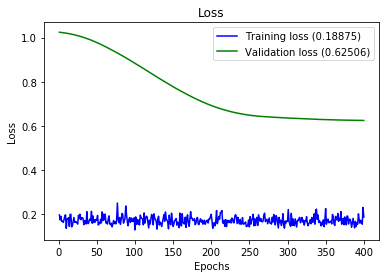

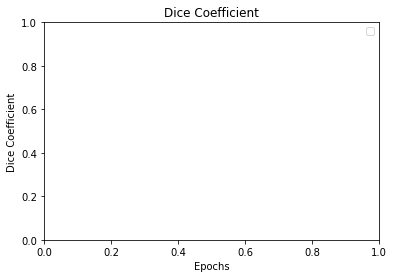

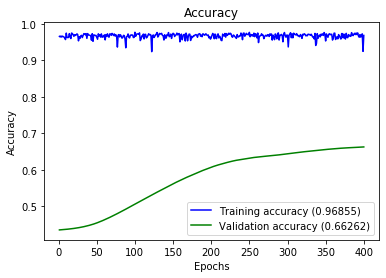

In [ ]:
location = "unetTR.pdf"
plot_history(results_01,location)

# EM Iteration


1
report_unet               precision    recall  f1-score   support

           0       0.68      0.69      0.69   2904206
           1       0.75      0.75      0.75   3700894

    accuracy                           0.72   6605100
   macro avg       0.72      0.72      0.72   6605100
weighted avg       0.72      0.72      0.72   6605100

accuracy_unet 0.7219117045919062
NN architecture
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placehol

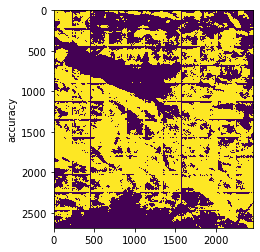

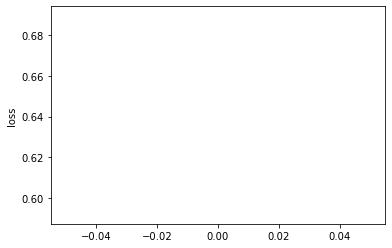

  time: 26s (wall 26s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.59e-01
  accuracy_average = 5.71e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.68e-01
  accuracy_average = 5.38e-01


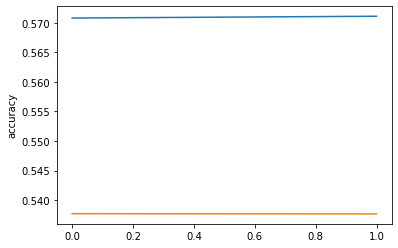

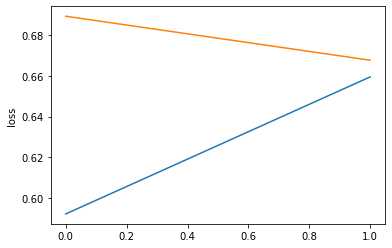

  time: 52s (wall 52s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.36e-01
  accuracy_average = 5.71e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.43e-01
  accuracy_average = 5.38e-01


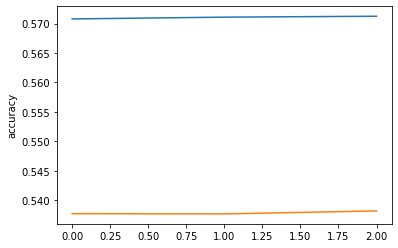

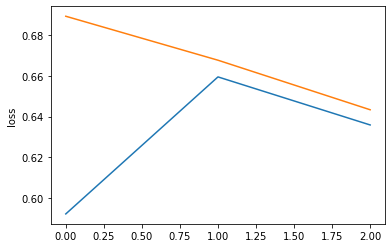

  time: 77s (wall 77s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.10e-01
  accuracy_average = 5.91e-01
  learning_rate = 9.90e-05, Validation_loss_average = 6.15e-01
  accuracy_average = 6.98e-01


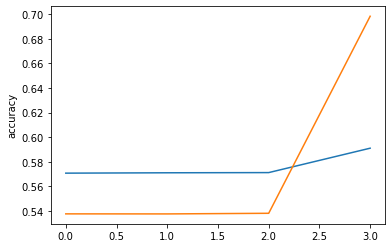

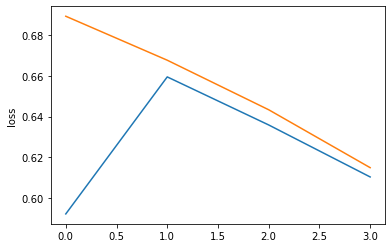

  time: 104s (wall 104s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.81e-01
  accuracy_average = 8.23e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.83e-01
  accuracy_average = 7.71e-01


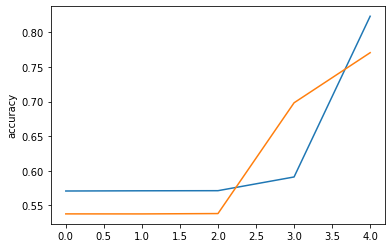

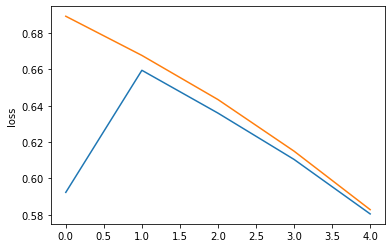

  time: 129s (wall 129s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.48e-01
  accuracy_average = 8.79e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.46e-01
  accuracy_average = 7.84e-01


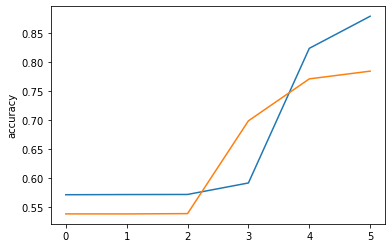

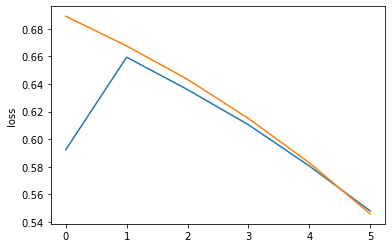

  time: 154s (wall 154s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.10e-01
  accuracy_average = 9.04e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.07e-01
  accuracy_average = 7.87e-01


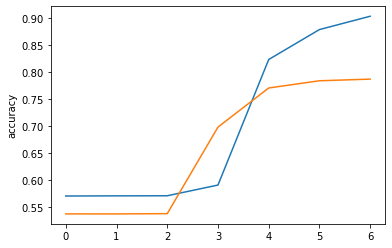

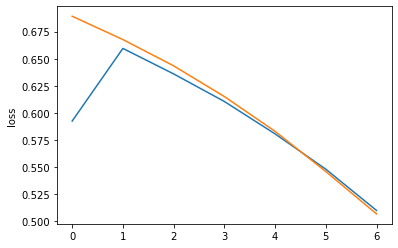

  time: 179s (wall 179s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.72e-01
  accuracy_average = 9.15e-01
  learning_rate = 9.80e-05, Validation_loss_average = 4.65e-01
  accuracy_average = 7.91e-01


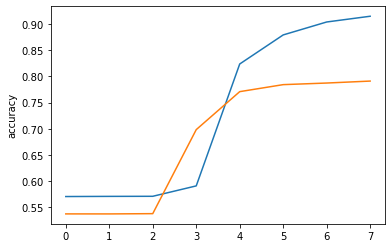

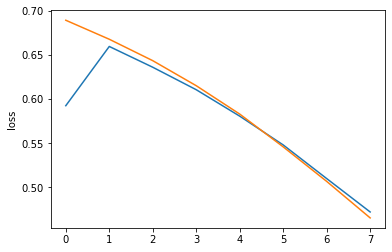

  time: 203s (wall 203s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.33e-01
  accuracy_average = 9.26e-01
  learning_rate = 9.80e-05, Validation_loss_average = 4.24e-01
  accuracy_average = 7.94e-01


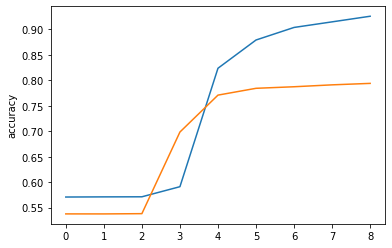

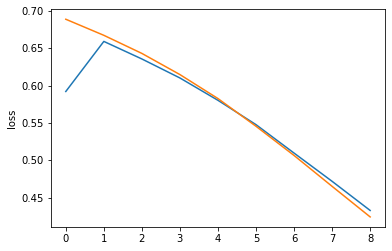

  time: 228s (wall 228s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.94e-01
  accuracy_average = 9.34e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.86e-01
  accuracy_average = 7.95e-01


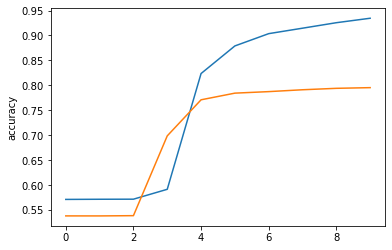

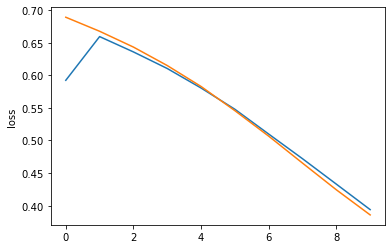

  time: 254s (wall 254s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.59e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.50e-01
  accuracy_average = 7.95e-01


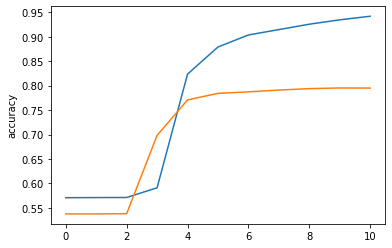

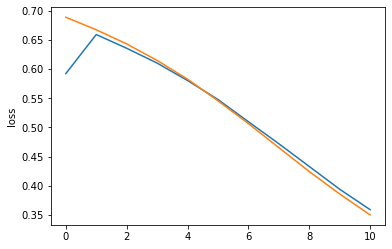

  time: 279s (wall 279s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 3.26e-01
  accuracy_average = 9.40e-01
  learning_rate = 9.70e-05, Validation_loss_average = 3.18e-01
  accuracy_average = 7.99e-01


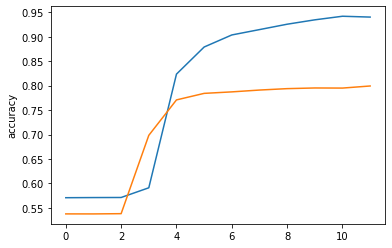

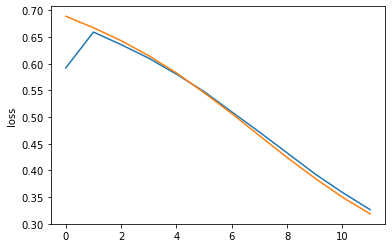

  time: 304s (wall 304s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 3.00e-01
  accuracy_average = 9.41e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.91e-01
  accuracy_average = 7.99e-01


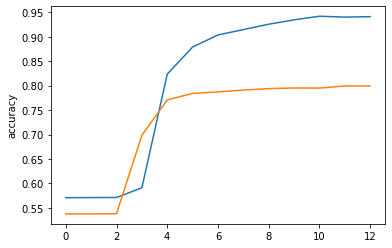

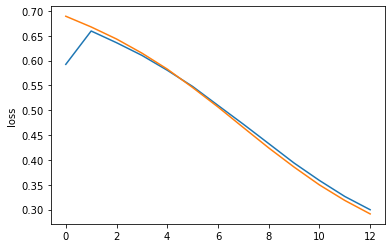

  time: 328s (wall 328s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.76e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.68e-01
  accuracy_average = 7.99e-01


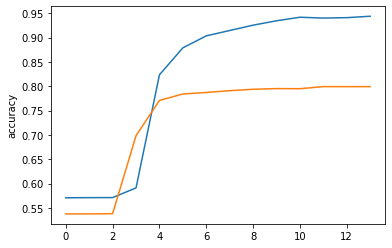

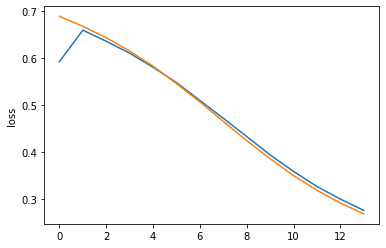

  time: 353s (wall 353s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.55e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.61e-05, Validation_loss_average = 2.49e-01
  accuracy_average = 7.99e-01


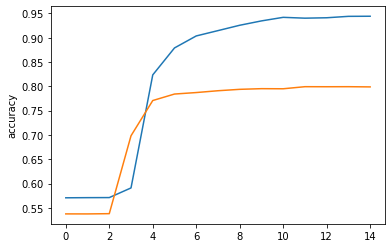

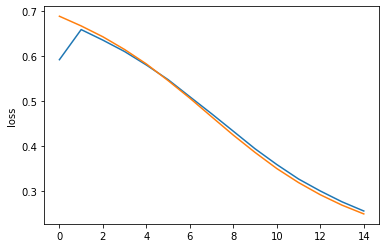

  time: 379s (wall 379s)
report_gnn:               precision    recall  f1-score   support

           0       0.77      0.73      0.75   2904206
           1       0.80      0.83      0.81   3700894

    accuracy                           0.79   6605100
   macro avg       0.79      0.78      0.78   6605100
weighted avg       0.79      0.79      0.79   6605100

ave_accuracy_gnn 0.786950386822304
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 6

No handles with labels found to put in legend.


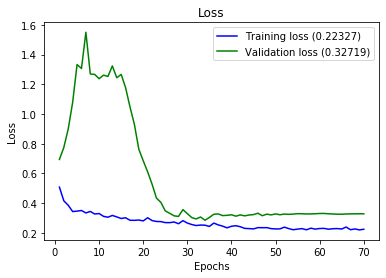

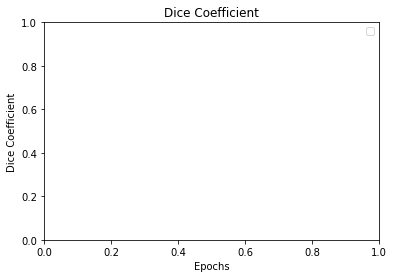

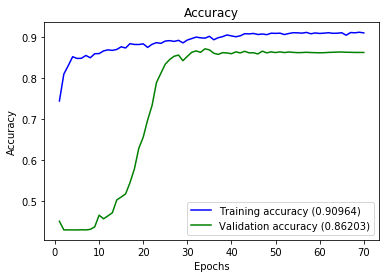

2
report_unet               precision    recall  f1-score   support

           0       0.81      0.74      0.77   2904206
           1       0.81      0.87      0.84   3700894

    accuracy                           0.81   6605100
   macro avg       0.81      0.80      0.81   6605100
weighted avg       0.81      0.81      0.81   6605100

accuracy_unet 0.8108202752418585
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

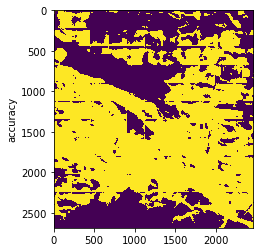

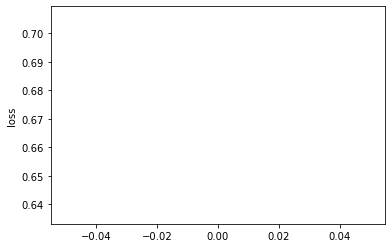

  time: 26s (wall 26s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.96e-01
  accuracy_average = 8.38e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.73e-01
  accuracy_average = 7.98e-01


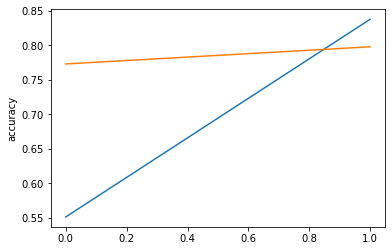

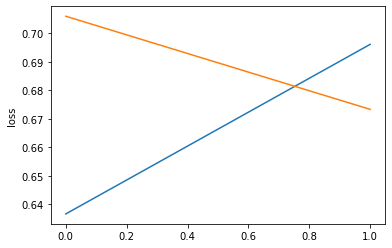

  time: 51s (wall 51s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.62e-01
  accuracy_average = 8.69e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.41e-01
  accuracy_average = 8.13e-01


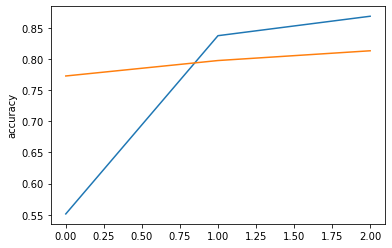

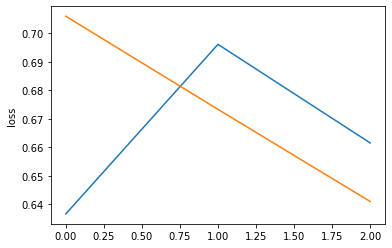

  time: 77s (wall 77s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.27e-01
  accuracy_average = 8.86e-01
  learning_rate = 9.90e-05, Validation_loss_average = 6.06e-01
  accuracy_average = 8.24e-01


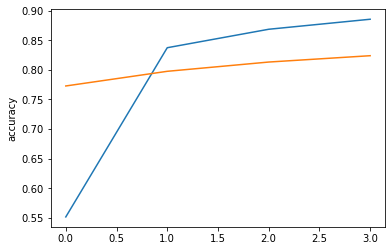

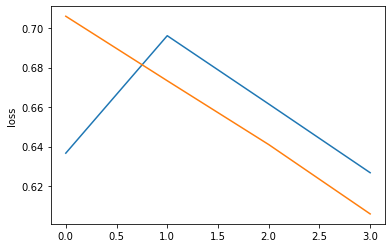

  time: 102s (wall 102s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.91e-01
  accuracy_average = 9.00e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.66e-01
  accuracy_average = 8.25e-01


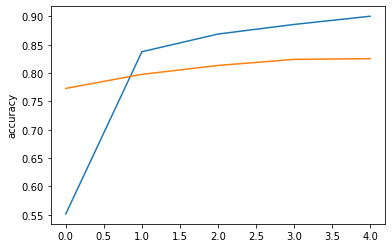

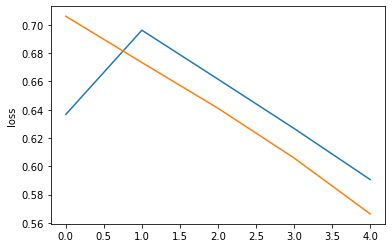

  time: 127s (wall 127s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.51e-01
  accuracy_average = 9.18e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.21e-01
  accuracy_average = 8.40e-01


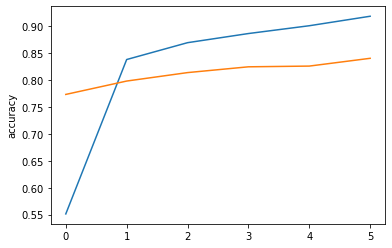

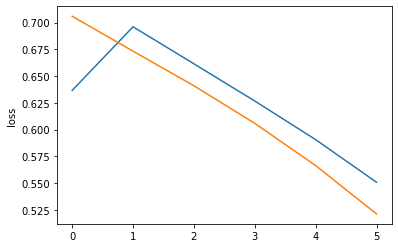

  time: 152s (wall 152s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.08e-01
  accuracy_average = 9.30e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.76e-01
  accuracy_average = 8.42e-01


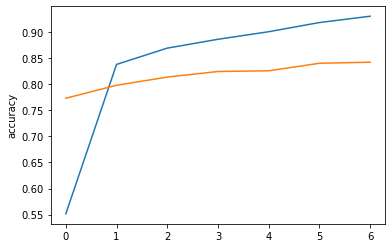

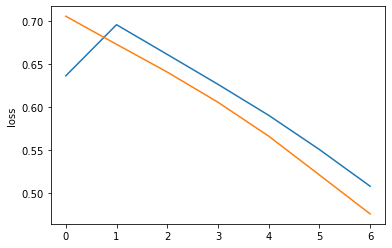

  time: 177s (wall 177s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.67e-01
  accuracy_average = 9.36e-01
  learning_rate = 9.80e-05, Validation_loss_average = 4.34e-01
  accuracy_average = 8.42e-01


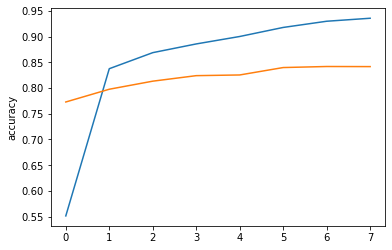

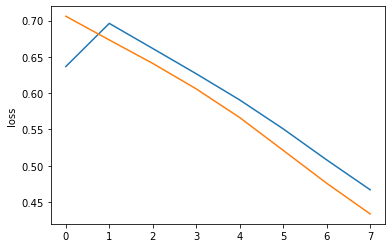

  time: 203s (wall 203s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.28e-01
  accuracy_average = 9.38e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.92e-01
  accuracy_average = 8.41e-01


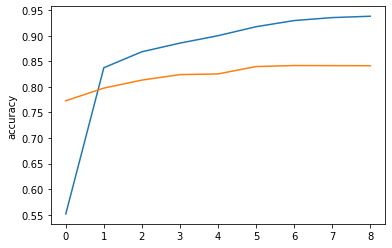

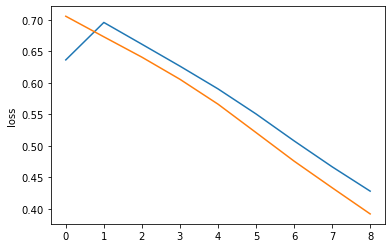

  time: 229s (wall 229s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.90e-01
  accuracy_average = 9.41e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.52e-01
  accuracy_average = 8.41e-01


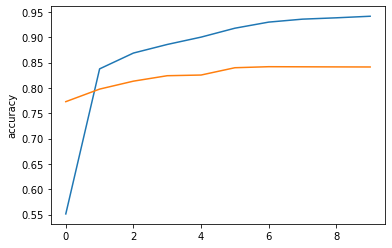

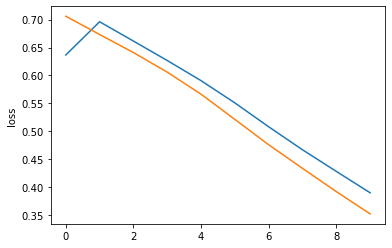

  time: 255s (wall 255s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.55e-01
  accuracy_average = 9.41e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.15e-01
  accuracy_average = 8.41e-01


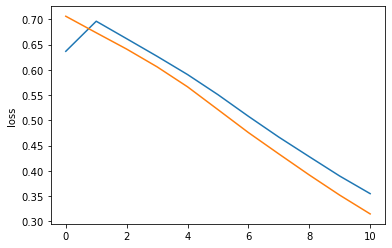

  time: 280s (wall 280s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 3.23e-01
  accuracy_average = 9.43e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.82e-01
  accuracy_average = 8.40e-01


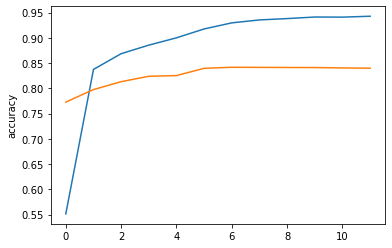

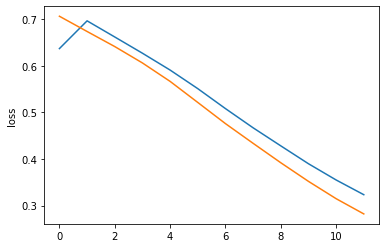

  time: 305s (wall 305s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.96e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.54e-01
  accuracy_average = 8.39e-01


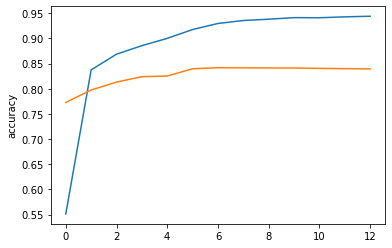

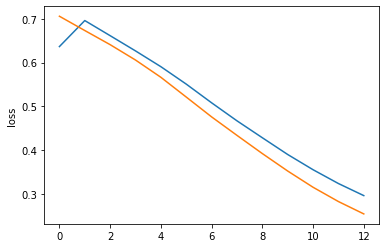

  time: 331s (wall 331s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.72e-01
  accuracy_average = 9.45e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.30e-01
  accuracy_average = 8.39e-01


  time: 356s (wall 356s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.52e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.61e-05, Validation_loss_average = 2.11e-01
  accuracy_average = 8.39e-01


  time: 383s (wall 383s)
report_gnn:               precision    recall  f1-score   support

           0       0.86      0.74      0.80   2904206
           1       0.82      0.90      0.86   3700894

    accuracy                           0.83   6605100
   macro avg       0.84      0.82      0.83   6605100
weighted avg       0.83      0.83      0.83   6605100

ave_accuracy_gnn 0.8316158725833068
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


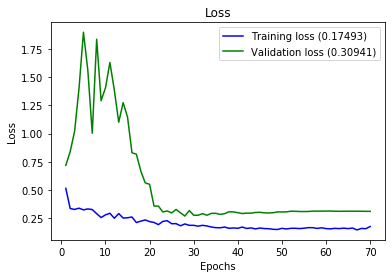

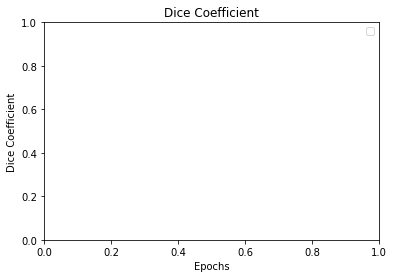

3
report_unet               precision    recall  f1-score   support

           0       0.89      0.73      0.80   2904206
           1       0.82      0.93      0.87   3700894

    accuracy                           0.84   6605100
   macro avg       0.85      0.83      0.84   6605100
weighted avg       0.85      0.84      0.84   6605100

accuracy_unet 0.8417633343931205
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

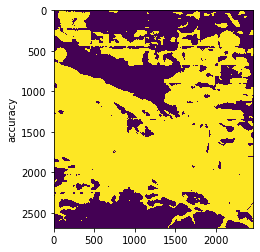

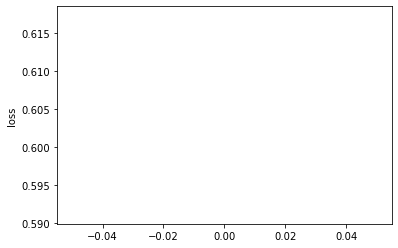

  time: 28s (wall 28s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.21e-01
  accuracy_average = 9.44e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.64e-01
  accuracy_average = 8.48e-01


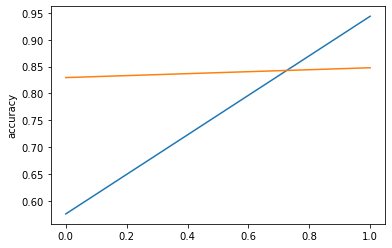

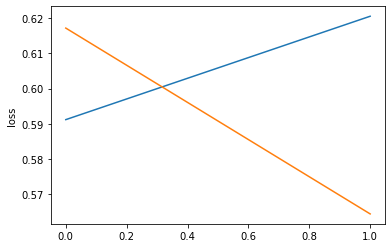

  time: 54s (wall 54s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 5.67e-01
  accuracy_average = 9.65e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.13e-01
  accuracy_average = 8.49e-01


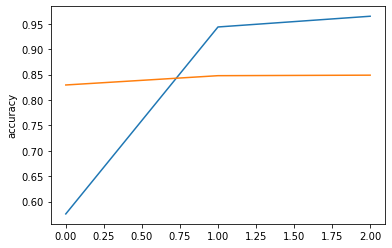

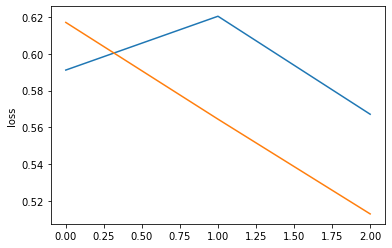

  time: 80s (wall 80s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.19e-01
  accuracy_average = 9.66e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.60e-01
  accuracy_average = 8.49e-01


  time: 107s (wall 107s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.70e-01
  accuracy_average = 9.63e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.06e-01
  accuracy_average = 8.52e-01


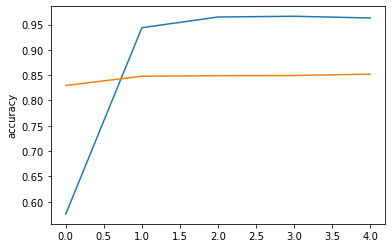

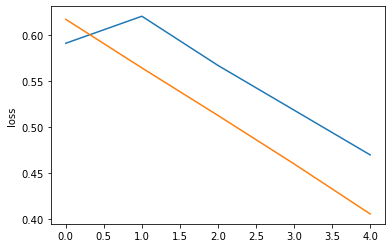

  time: 134s (wall 134s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.21e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.53e-01
  accuracy_average = 8.53e-01


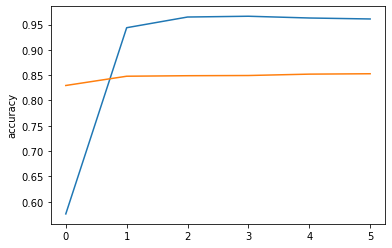

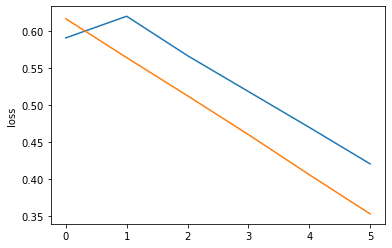

  time: 160s (wall 160s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 3.73e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.04e-01
  accuracy_average = 8.53e-01


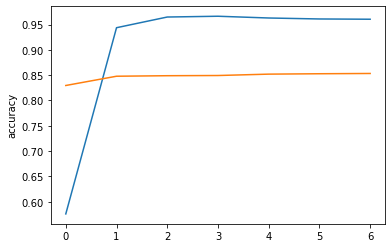

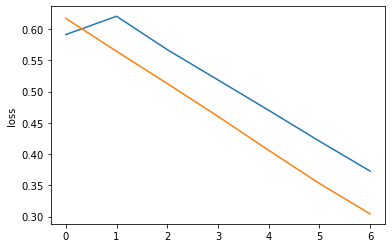

  time: 188s (wall 188s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.28e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.61e-01
  accuracy_average = 8.54e-01


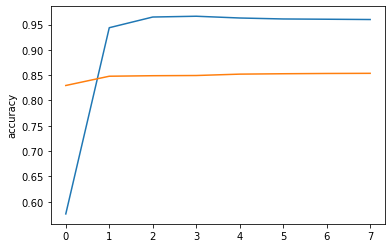

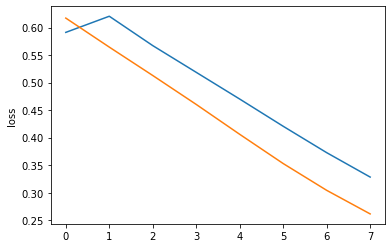

  time: 215s (wall 215s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.91e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.26e-01
  accuracy_average = 8.54e-01


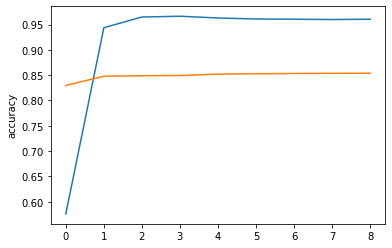

  time: 242s (wall 242s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.59e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.97e-01
  accuracy_average = 8.54e-01


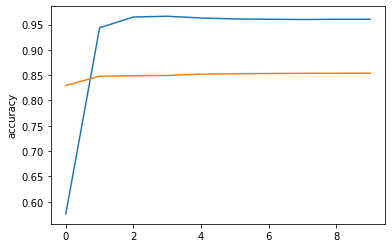

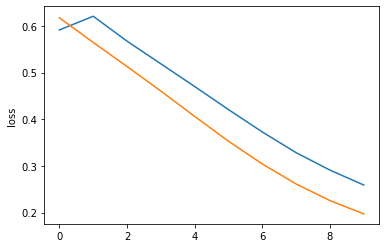

  time: 268s (wall 268s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.35e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.75e-01
  accuracy_average = 8.54e-01


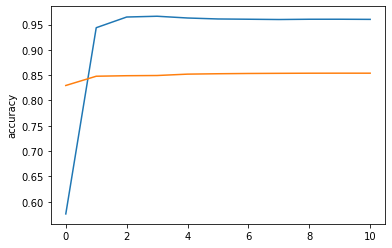

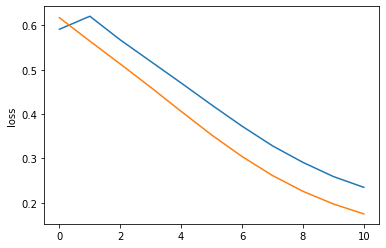

  time: 295s (wall 295s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.15e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.57e-01
  accuracy_average = 8.54e-01


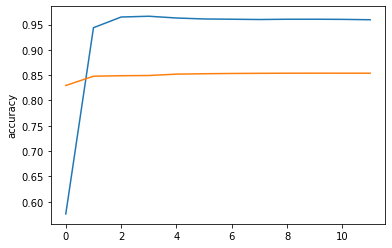

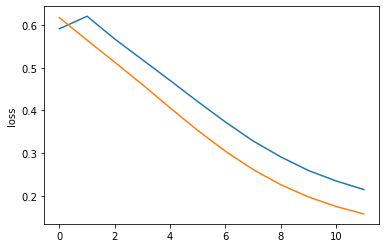

  time: 322s (wall 322s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.99e-01
  accuracy_average = 9.59e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.44e-01
  accuracy_average = 8.54e-01


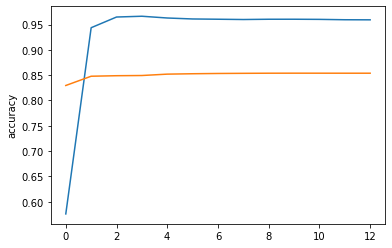

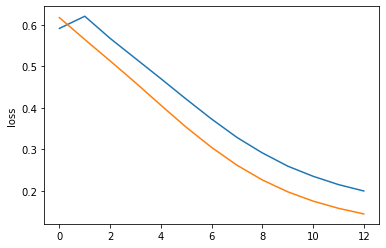

  time: 349s (wall 349s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.88e-01
  accuracy_average = 9.59e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.33e-01
  accuracy_average = 8.54e-01


  time: 375s (wall 375s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 1.77e-01
  accuracy_average = 9.59e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.25e-01
  accuracy_average = 8.54e-01


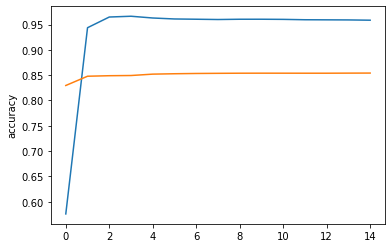

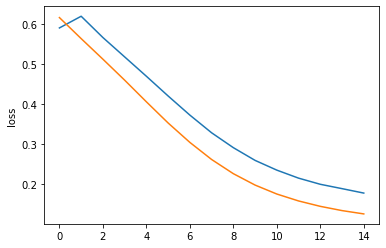

  time: 402s (wall 402s)
report_gnn:               precision    recall  f1-score   support

           0       0.91      0.73      0.81   2904206
           1       0.82      0.94      0.87   3700894

    accuracy                           0.85   6605100
   macro avg       0.86      0.84      0.84   6605100
weighted avg       0.86      0.85      0.85   6605100

ave_accuracy_gnn 0.8488917654539674
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


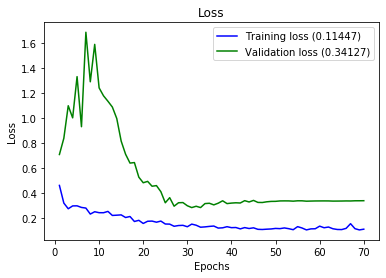

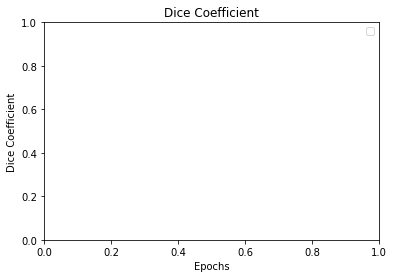

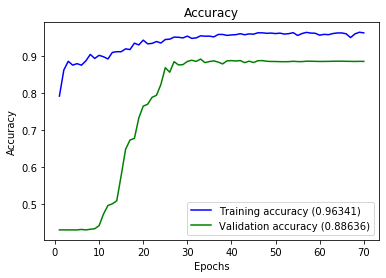

4
report_unet               precision    recall  f1-score   support

           0       0.90      0.73      0.81   2904206
           1       0.82      0.93      0.87   3700894

    accuracy                           0.85   6605100
   macro avg       0.86      0.83      0.84   6605100
weighted avg       0.85      0.85      0.84   6605100

accuracy_unet 0.846789753372394
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", d

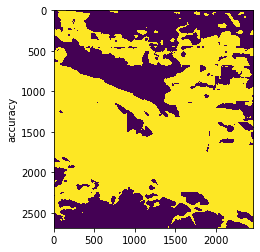

  time: 29s (wall 29s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.25e-01
  accuracy_average = 9.40e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.69e-01
  accuracy_average = 8.58e-01


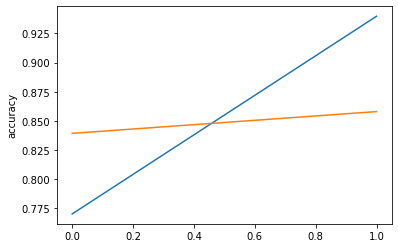

  time: 56s (wall 56s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 5.63e-01
  accuracy_average = 9.53e-01
  learning_rate = 1.00e-04, Validation_loss_average = 4.99e-01
  accuracy_average = 8.58e-01


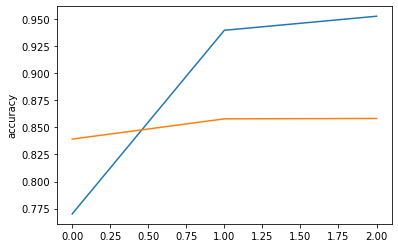

  time: 83s (wall 83s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.00e-01
  accuracy_average = 9.54e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.31e-01
  accuracy_average = 8.59e-01


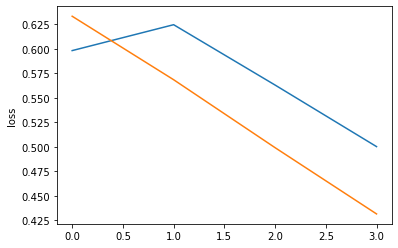

  time: 110s (wall 110s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.41e-01
  accuracy_average = 9.54e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.68e-01
  accuracy_average = 8.58e-01


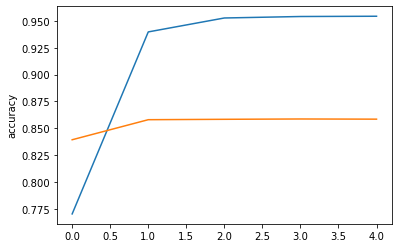

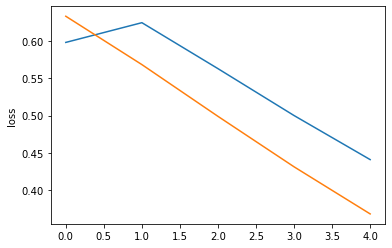

  time: 137s (wall 137s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 3.86e-01
  accuracy_average = 9.53e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.13e-01
  accuracy_average = 8.58e-01


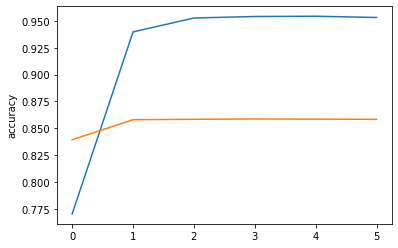

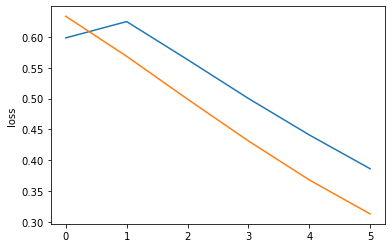

  time: 164s (wall 164s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 3.39e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.90e-05, Validation_loss_average = 2.66e-01
  accuracy_average = 8.58e-01


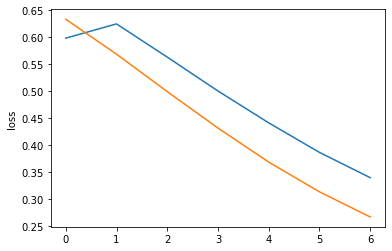

  time: 191s (wall 191s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.00e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.28e-01
  accuracy_average = 8.58e-01


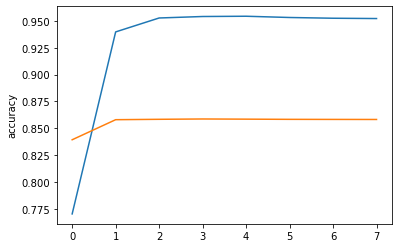

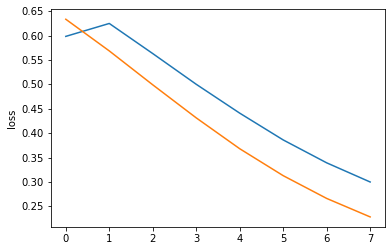

  time: 219s (wall 219s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.68e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.00e-01
  accuracy_average = 8.58e-01


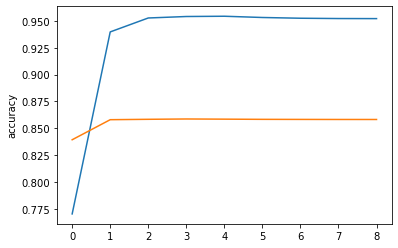

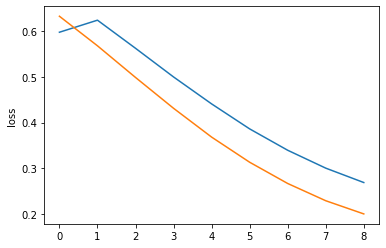

  time: 246s (wall 246s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.44e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.77e-01
  accuracy_average = 8.58e-01


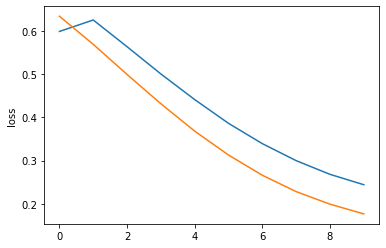

  time: 273s (wall 273s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.25e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.59e-01
  accuracy_average = 8.58e-01


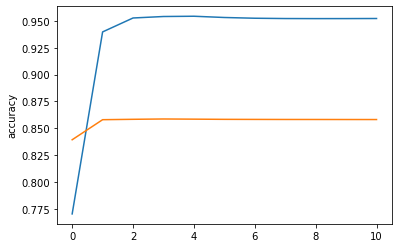

  time: 299s (wall 299s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.10e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.45e-01
  accuracy_average = 8.58e-01


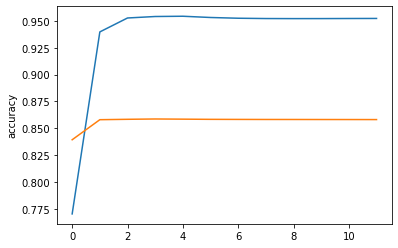

  time: 326s (wall 326s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.98e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.34e-01
  accuracy_average = 8.58e-01


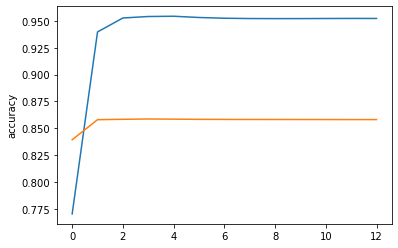

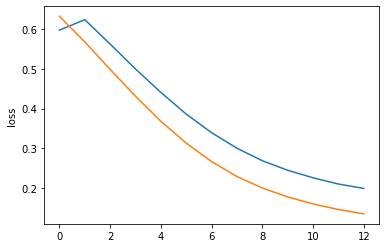

  time: 352s (wall 352s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.90e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.25e-01
  accuracy_average = 8.58e-01


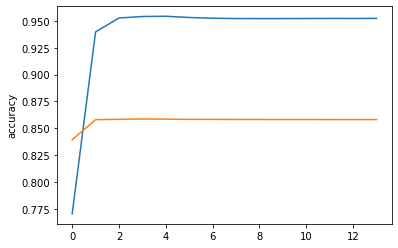

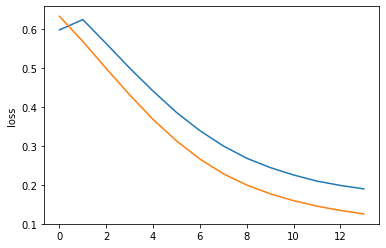

  time: 380s (wall 380s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 1.81e-01
  accuracy_average = 9.52e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.18e-01
  accuracy_average = 8.58e-01


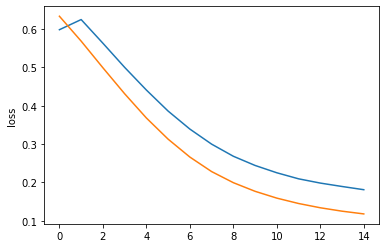

  time: 407s (wall 407s)
report_gnn:               precision    recall  f1-score   support

           0       0.92      0.73      0.81   2904206
           1       0.82      0.95      0.88   3700894

    accuracy                           0.85   6605100
   macro avg       0.87      0.84      0.85   6605100
weighted avg       0.86      0.85      0.85   6605100

ave_accuracy_gnn 0.851978925375846
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 6

No handles with labels found to put in legend.


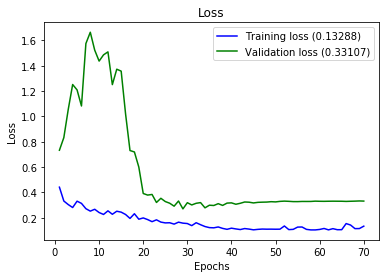

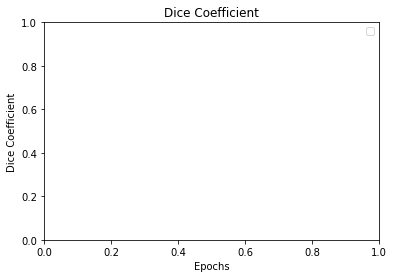

5
report_unet               precision    recall  f1-score   support

           0       0.95      0.74      0.83   2904206
           1       0.82      0.97      0.89   3700894

    accuracy                           0.87   6605100
   macro avg       0.89      0.85      0.86   6605100
weighted avg       0.88      0.87      0.86   6605100

accuracy_unet 0.866547667711314
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", d

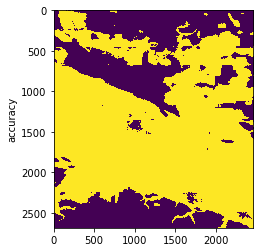

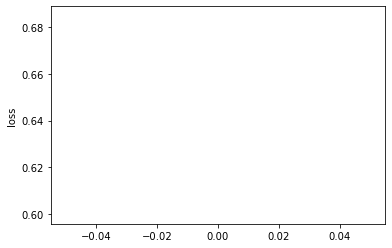

  time: 28s (wall 28s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.58e-01
  accuracy_average = 5.80e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.42e-01
  accuracy_average = 5.81e-01


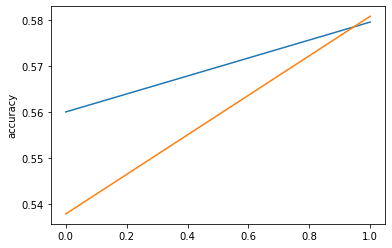

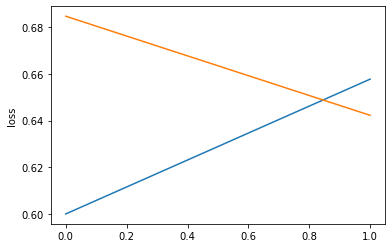

  time: 54s (wall 54s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.23e-01
  accuracy_average = 8.34e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.96e-01
  accuracy_average = 8.67e-01


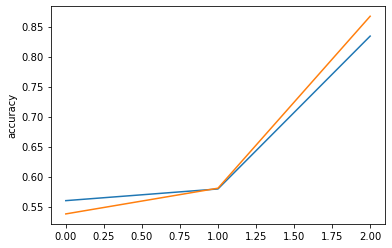

  time: 81s (wall 81s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.79e-01
  accuracy_average = 8.83e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.38e-01
  accuracy_average = 8.65e-01


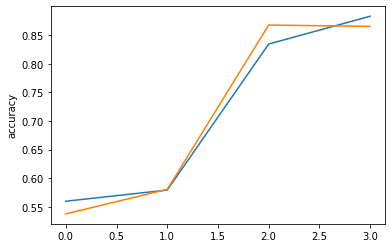

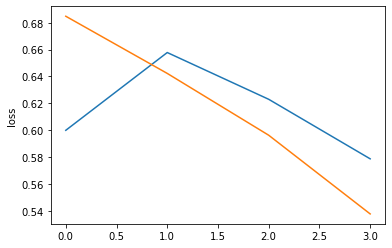

  time: 108s (wall 108s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.27e-01
  accuracy_average = 9.01e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.77e-01
  accuracy_average = 8.70e-01


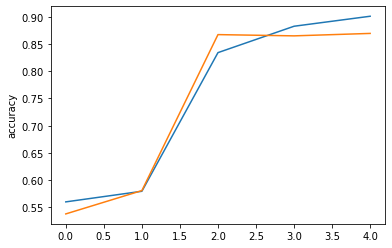

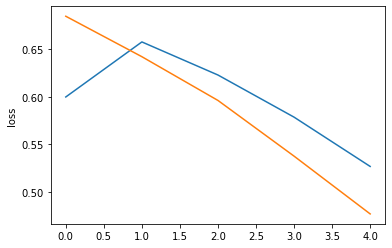

  time: 135s (wall 135s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.74e-01
  accuracy_average = 9.27e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.14e-01
  accuracy_average = 8.78e-01


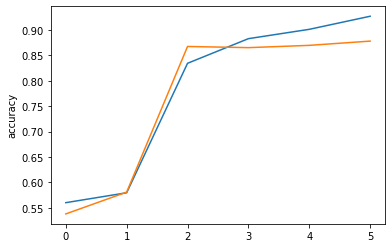

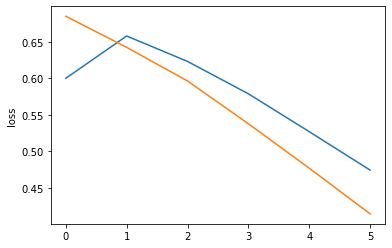

  time: 161s (wall 161s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.22e-01
  accuracy_average = 9.36e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.55e-01
  accuracy_average = 8.77e-01


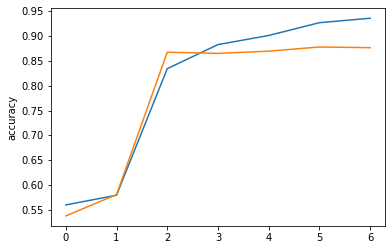

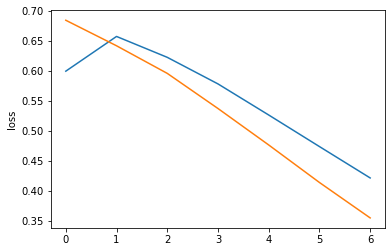

  time: 188s (wall 188s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.75e-01
  accuracy_average = 9.37e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.05e-01
  accuracy_average = 8.76e-01


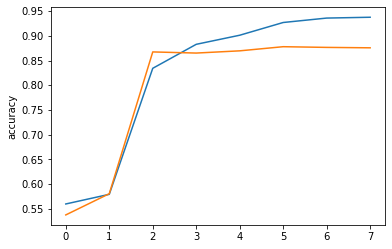

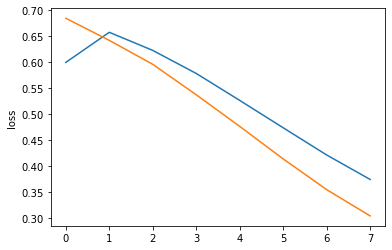

  time: 215s (wall 215s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.33e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.62e-01
  accuracy_average = 8.75e-01


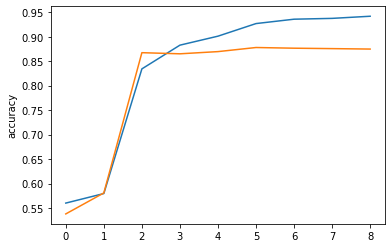

  time: 242s (wall 242s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.99e-01
  accuracy_average = 9.43e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.26e-01
  accuracy_average = 8.74e-01


  time: 270s (wall 270s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.70e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.97e-01
  accuracy_average = 8.74e-01


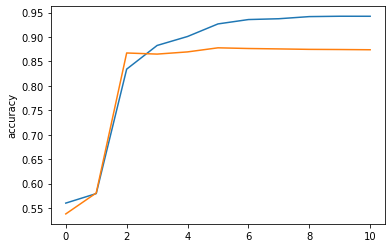

  time: 297s (wall 297s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.48e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.74e-01
  accuracy_average = 8.74e-01


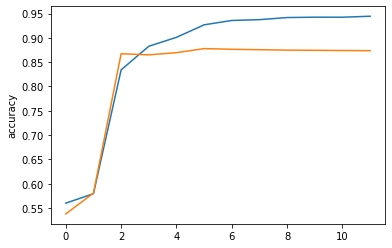

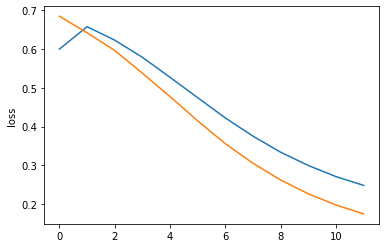

  time: 324s (wall 324s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.30e-01
  accuracy_average = 9.45e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.56e-01
  accuracy_average = 8.73e-01


  time: 352s (wall 352s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.16e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.42e-01
  accuracy_average = 8.73e-01


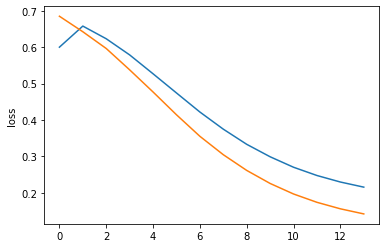

  time: 380s (wall 380s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.04e-01
  accuracy_average = 9.48e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.31e-01
  accuracy_average = 8.73e-01


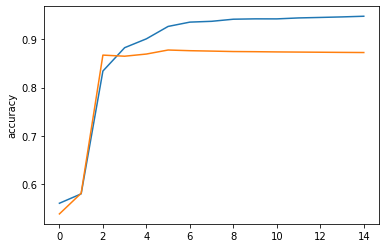

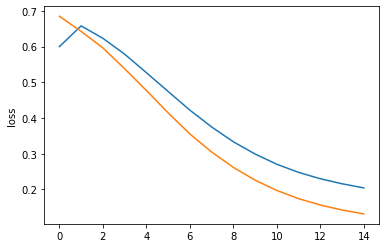

  time: 407s (wall 407s)
report_gnn:               precision    recall  f1-score   support

           0       0.96      0.73      0.83   2904206
           1       0.82      0.97      0.89   3700894

    accuracy                           0.87   6605100
   macro avg       0.89      0.85      0.86   6605100
weighted avg       0.88      0.87      0.87   6605100

ave_accuracy_gnn 0.8683850358056653
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


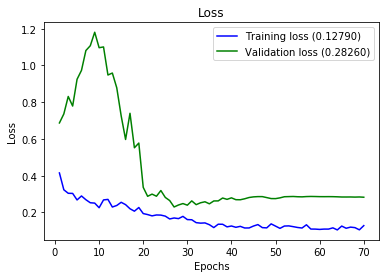

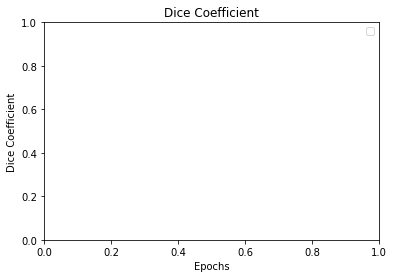

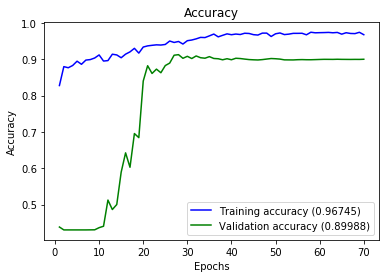

6
report_unet               precision    recall  f1-score   support

           0       0.97      0.73      0.83   2904206
           1       0.82      0.98      0.90   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.86      0.86   6605100
weighted avg       0.89      0.87      0.87   6605100

accuracy_unet 0.8720297951582868
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

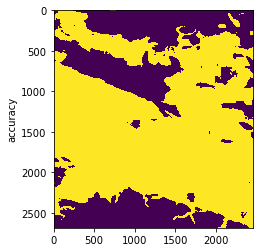

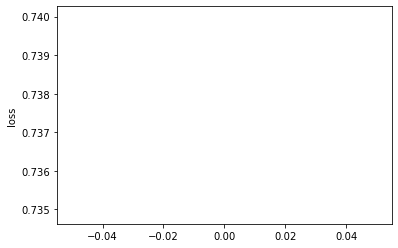

  time: 29s (wall 29s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 7.34e-01
  accuracy_average = 5.07e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.60e-01
  accuracy_average = 8.53e-01


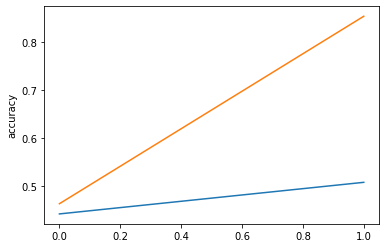

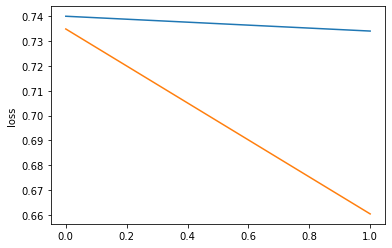

  time: 56s (wall 56s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.62e-01
  accuracy_average = 9.12e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.01e-01
  accuracy_average = 8.78e-01


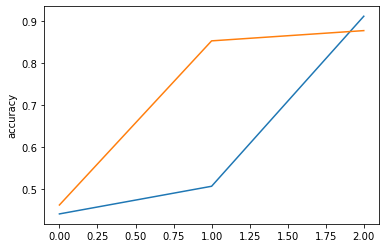

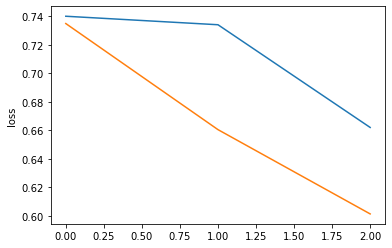

  time: 84s (wall 84s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.05e-01
  accuracy_average = 9.28e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.44e-01
  accuracy_average = 8.81e-01


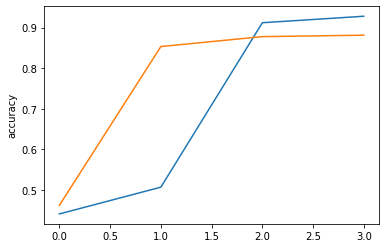

  time: 112s (wall 112s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.51e-01
  accuracy_average = 9.36e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.87e-01
  accuracy_average = 8.82e-01


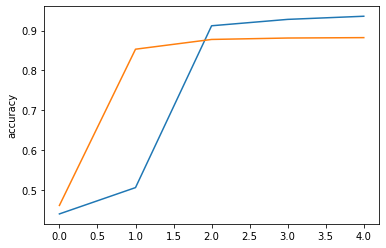

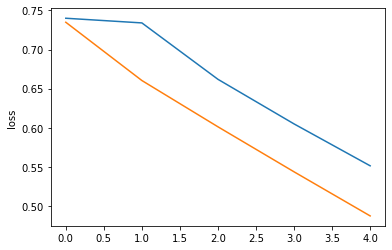

  time: 138s (wall 138s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.01e-01
  accuracy_average = 9.39e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.30e-01
  accuracy_average = 8.82e-01


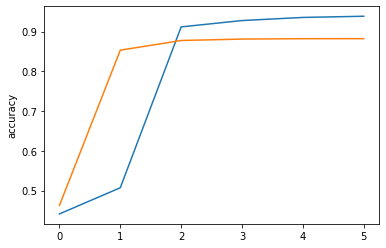

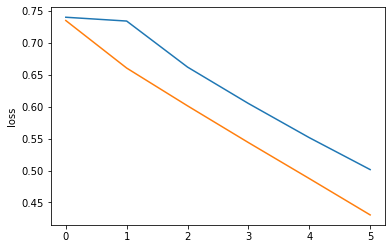

  time: 166s (wall 166s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.52e-01
  accuracy_average = 9.41e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.75e-01
  accuracy_average = 8.82e-01


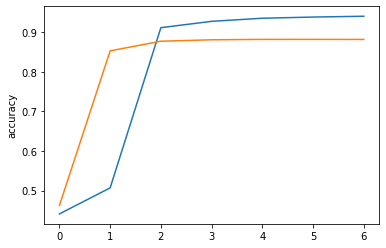

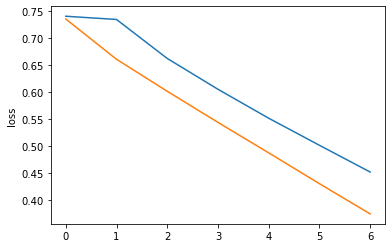

  time: 193s (wall 193s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.03e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.22e-01
  accuracy_average = 8.82e-01


  time: 221s (wall 221s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.58e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.76e-01
  accuracy_average = 8.82e-01


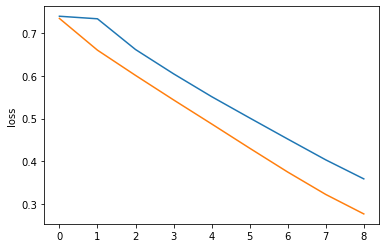

  time: 249s (wall 249s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.20e-01
  accuracy_average = 9.43e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.38e-01
  accuracy_average = 8.82e-01


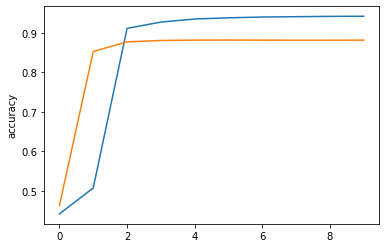

  time: 277s (wall 277s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.88e-01
  accuracy_average = 9.43e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.06e-01
  accuracy_average = 8.82e-01


  time: 304s (wall 304s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.62e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.81e-01
  accuracy_average = 8.82e-01


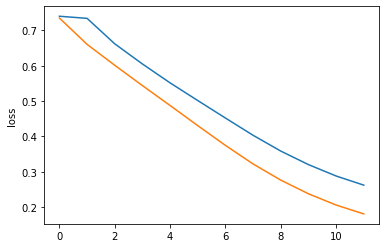

  time: 331s (wall 331s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.42e-01
  accuracy_average = 9.45e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.61e-01
  accuracy_average = 8.81e-01


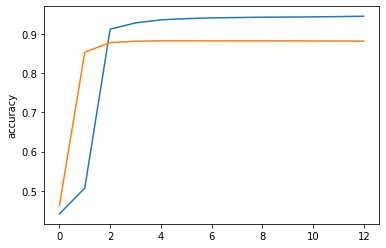

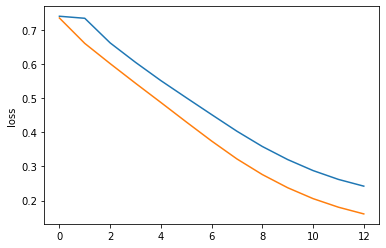

  time: 358s (wall 358s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.25e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.46e-01
  accuracy_average = 8.81e-01


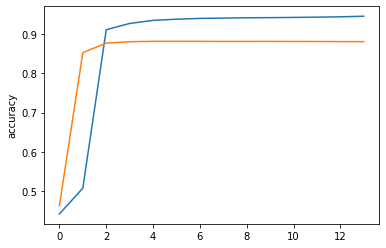

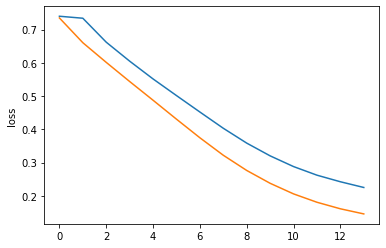

  time: 385s (wall 385s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.14e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.34e-01
  accuracy_average = 8.81e-01


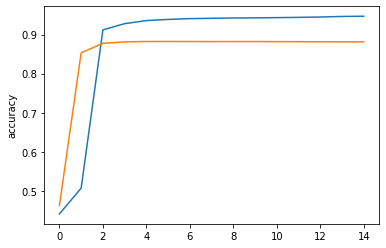

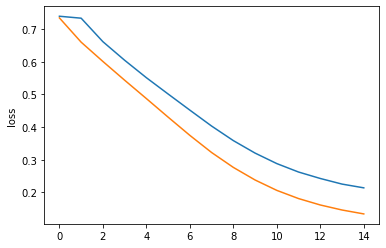

  time: 413s (wall 413s)
report_gnn:               precision    recall  f1-score   support

           0       0.97      0.73      0.83   2904206
           1       0.82      0.98      0.90   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.86      0.86   6605100
weighted avg       0.89      0.87      0.87   6605100

ave_accuracy_gnn 0.8711463868828633
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


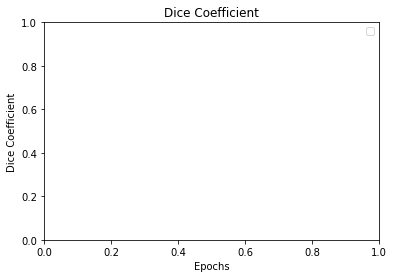

7
report_unet               precision    recall  f1-score   support

           0       0.98      0.71      0.82   2904206
           1       0.81      0.99      0.89   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.85      0.86   6605100
weighted avg       0.89      0.87      0.86   6605100

accuracy_unet 0.8663608423793735
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

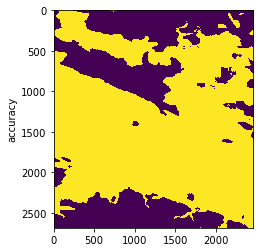

  time: 29s (wall 29s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.86e-01
  accuracy_average = 5.72e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.81e-01
  accuracy_average = 5.54e-01


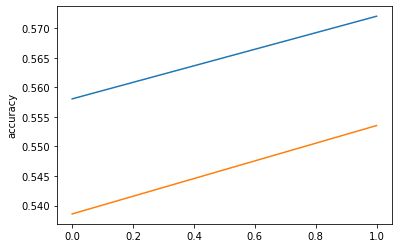

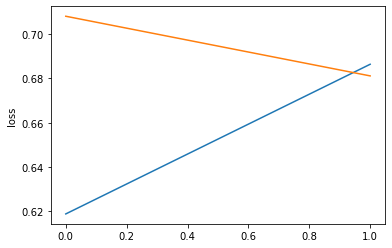

  time: 57s (wall 57s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.60e-01
  accuracy_average = 6.27e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.51e-01
  accuracy_average = 8.14e-01


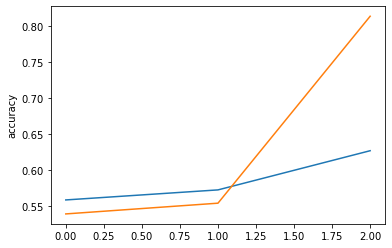

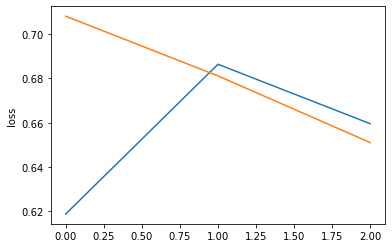

  time: 84s (wall 84s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.30e-01
  accuracy_average = 8.57e-01
  learning_rate = 9.90e-05, Validation_loss_average = 6.16e-01
  accuracy_average = 8.67e-01


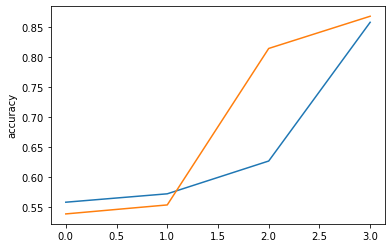

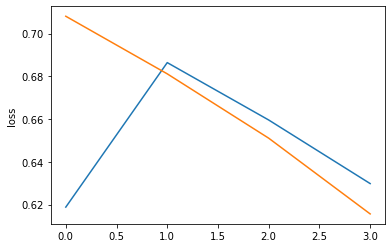

  time: 112s (wall 112s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.96e-01
  accuracy_average = 9.01e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.73e-01
  accuracy_average = 8.68e-01


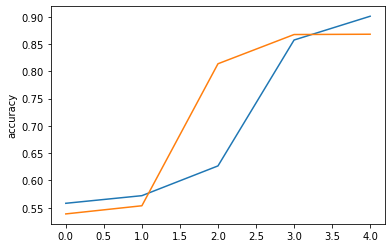

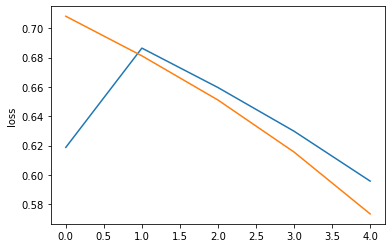

  time: 140s (wall 140s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.56e-01
  accuracy_average = 9.16e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.23e-01
  accuracy_average = 8.67e-01


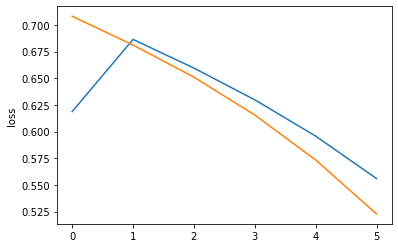

  time: 168s (wall 168s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.11e-01
  accuracy_average = 9.26e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.70e-01
  accuracy_average = 8.65e-01


  time: 195s (wall 195s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.63e-01
  accuracy_average = 9.50e-01
  learning_rate = 9.80e-05, Validation_loss_average = 4.14e-01
  accuracy_average = 8.83e-01


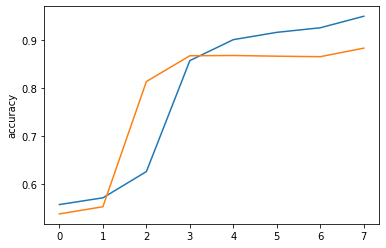

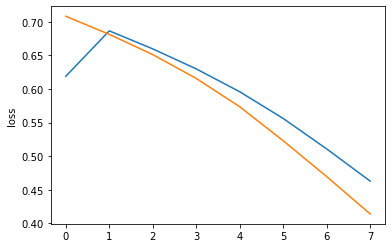

  time: 223s (wall 223s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.16e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.58e-01
  accuracy_average = 8.81e-01


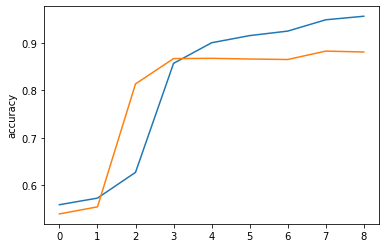

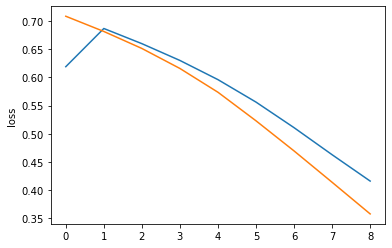

  time: 251s (wall 251s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.68e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.05e-01
  accuracy_average = 8.81e-01


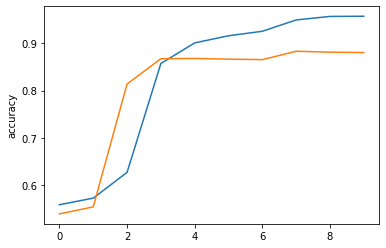

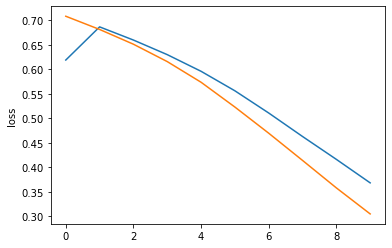

  time: 279s (wall 279s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.25e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.59e-01
  accuracy_average = 8.80e-01


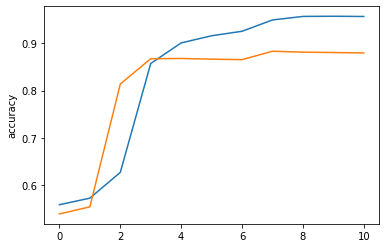

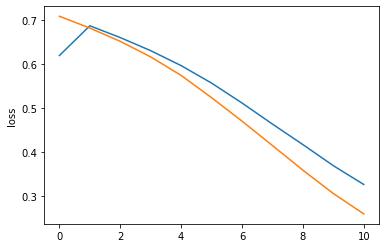

  time: 306s (wall 306s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.89e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.20e-01
  accuracy_average = 8.79e-01


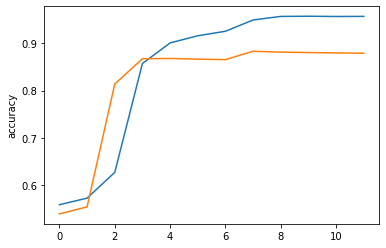

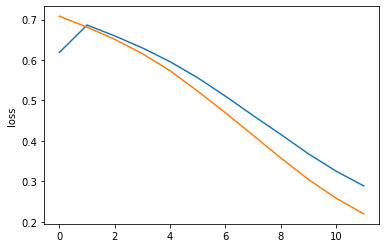

  time: 334s (wall 334s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.58e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.88e-01
  accuracy_average = 8.78e-01


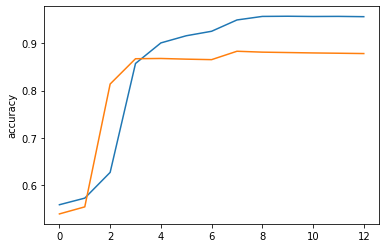

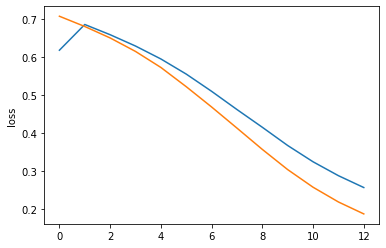

  time: 361s (wall 361s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.33e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.64e-01
  accuracy_average = 8.78e-01


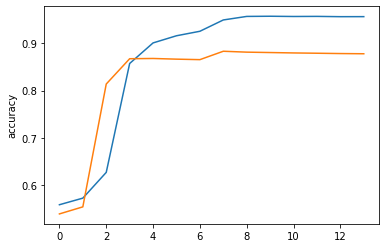

  time: 387s (wall 387s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.13e-01
  accuracy_average = 9.57e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.45e-01
  accuracy_average = 8.78e-01


  time: 415s (wall 415s)
report_gnn:               precision    recall  f1-score   support

           0       0.98      0.71      0.83   2904206
           1       0.82      0.99      0.89   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.85      0.86   6605100
weighted avg       0.89      0.87      0.86   6605100

ave_accuracy_gnn 0.8679199406519205
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


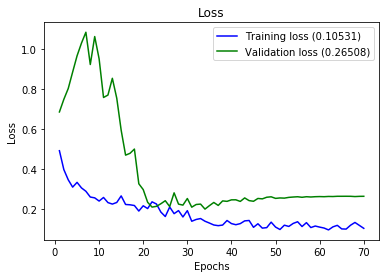

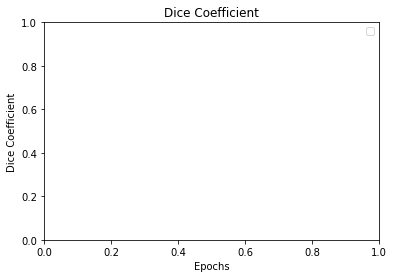

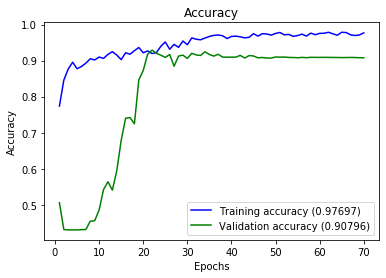

8
report_unet               precision    recall  f1-score   support

           0       0.97      0.73      0.84   2904206
           1       0.82      0.98      0.90   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.86      0.87   6605100
weighted avg       0.89      0.87      0.87   6605100

accuracy_unet 0.8735792039484641
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

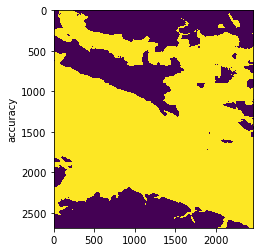

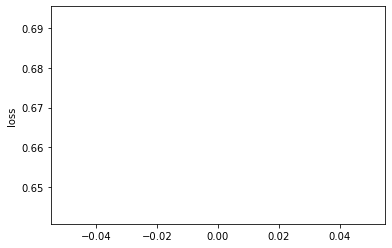

  time: 29s (wall 29s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 7.06e-01
  accuracy_average = 4.87e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.60e-01
  accuracy_average = 8.05e-01


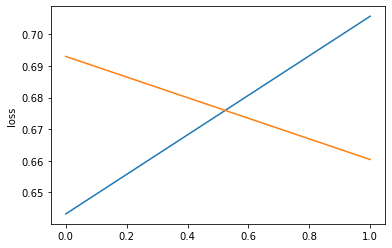

  time: 56s (wall 56s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.75e-01
  accuracy_average = 8.43e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.26e-01
  accuracy_average = 8.46e-01


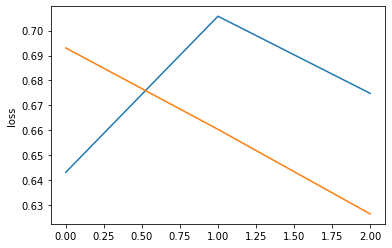

  time: 84s (wall 84s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.43e-01
  accuracy_average = 9.00e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.88e-01
  accuracy_average = 8.81e-01


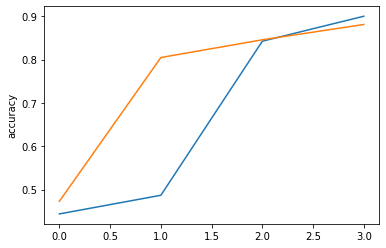

  time: 113s (wall 113s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 6.08e-01
  accuracy_average = 9.19e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.47e-01
  accuracy_average = 8.84e-01


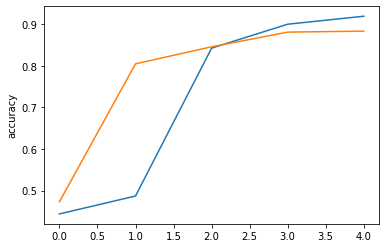

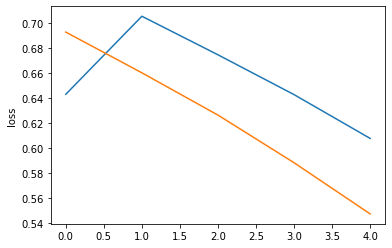

  time: 143s (wall 143s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.70e-01
  accuracy_average = 9.31e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.02e-01
  accuracy_average = 8.85e-01


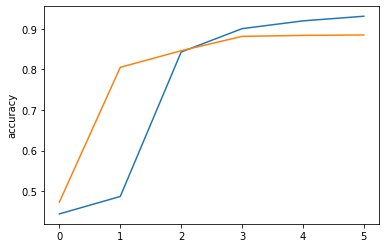

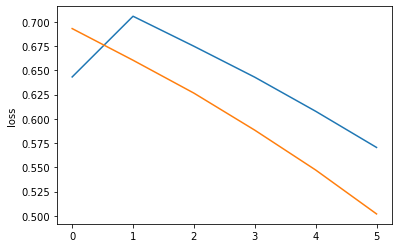

  time: 175s (wall 175s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.30e-01
  accuracy_average = 9.37e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.53e-01
  accuracy_average = 8.85e-01


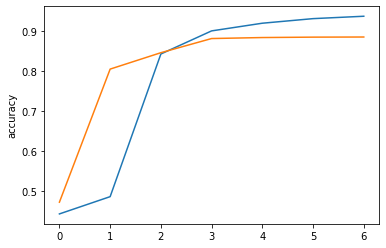

  time: 205s (wall 205s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.86e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.80e-05, Validation_loss_average = 4.04e-01
  accuracy_average = 8.86e-01


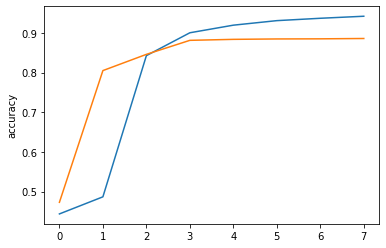

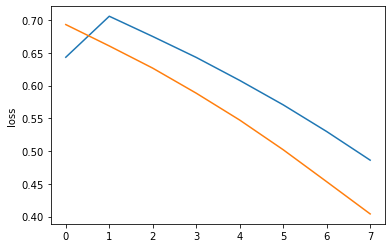

  time: 234s (wall 234s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 4.41e-01
  accuracy_average = 9.45e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.55e-01
  accuracy_average = 8.86e-01


  time: 263s (wall 263s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.97e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.80e-05, Validation_loss_average = 3.07e-01
  accuracy_average = 8.87e-01


  time: 291s (wall 291s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.54e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.65e-01
  accuracy_average = 8.87e-01


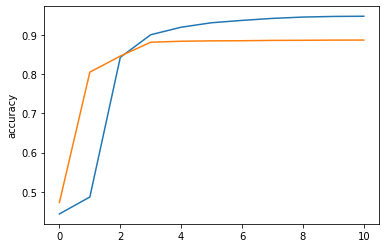

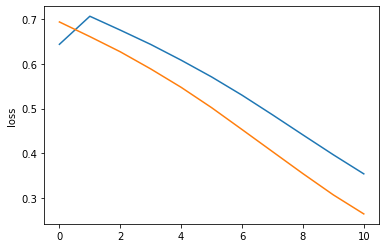

  time: 318s (wall 318s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 3.16e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.70e-05, Validation_loss_average = 2.29e-01
  accuracy_average = 8.87e-01


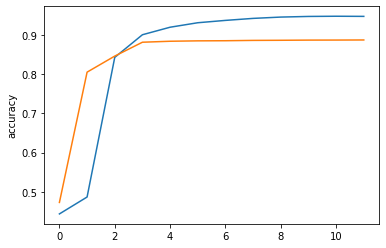

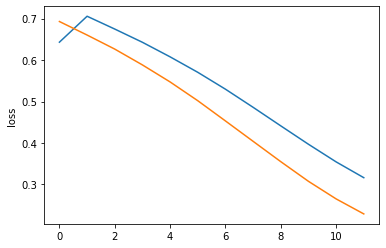

  time: 346s (wall 346s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.85e-01
  accuracy_average = 9.48e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.99e-01
  accuracy_average = 8.87e-01


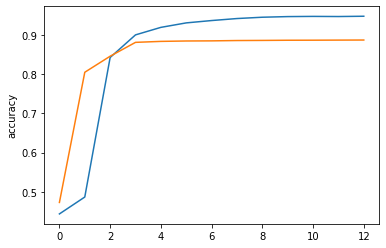

  time: 374s (wall 374s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.57e-01
  accuracy_average = 9.48e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.74e-01
  accuracy_average = 8.87e-01


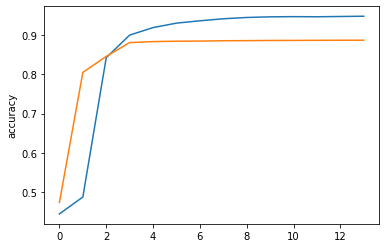

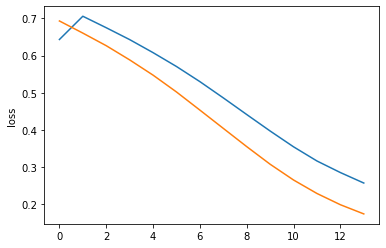

  time: 402s (wall 402s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 2.37e-01
  accuracy_average = 9.49e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.54e-01
  accuracy_average = 8.87e-01


  time: 429s (wall 429s)
report_gnn:               precision    recall  f1-score   support

           0       0.98      0.73      0.83   2904206
           1       0.82      0.99      0.90   3700894

    accuracy                           0.87   6605100
   macro avg       0.90      0.86      0.86   6605100
weighted avg       0.89      0.87      0.87   6605100

ave_accuracy_gnn 0.8718565956609287
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

257/257 [==============================] - 8s 31ms/step - loss: 0.1038 - accuracy: 0.9738 - val_loss: 0.2334 - val_accuracy: 0.9191
Epoch 47/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0974 - accuracy: 0.9757 - val_loss: 0.2300 - val_accuracy: 0.9204
Epoch 48/70
257/257 [==============================] - 8s 31ms/step - loss: 0.1018 - accuracy: 0.9765 - val_loss: 0.2292 - val_accuracy: 0.9208
Epoch 49/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0959 - accuracy: 0.9742 - val_loss: 0.2296 - val_accuracy: 0.9211
Epoch 50/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0901 - accuracy: 0.9774 - val_loss: 0.2311 - val_accuracy: 0.9208

Epoch 00050: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 51/70
257/257 [==============================] - 8s 31ms/step - loss: 0.1031 - accuracy: 0.9711 - val_loss: 0.2329 - val_accuracy: 0.9201
Epoch 52/70
257/257 [==============================] - 8s 31ms/step 

No handles with labels found to put in legend.



Epoch 00070: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.


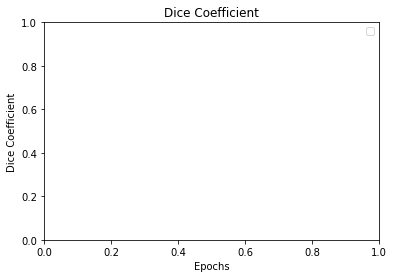

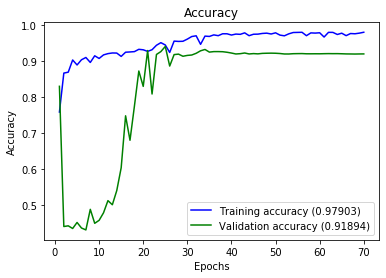

9
report_unet               precision    recall  f1-score   support

           0       0.97      0.77      0.86   2904206
           1       0.84      0.98      0.91   3700894

    accuracy                           0.89   6605100
   macro avg       0.91      0.87      0.88   6605100
weighted avg       0.90      0.89      0.89   6605100

accuracy_unet 0.8876322841440705
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", 

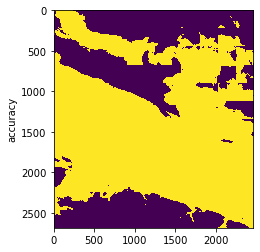

  time: 30s (wall 30s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.26e-01
  accuracy_average = 9.26e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.63e-01
  accuracy_average = 9.05e-01


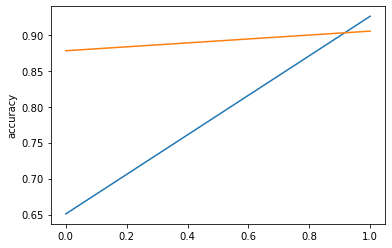

  time: 58s (wall 58s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 5.66e-01
  accuracy_average = 9.40e-01
  learning_rate = 1.00e-04, Validation_loss_average = 4.95e-01
  accuracy_average = 9.05e-01


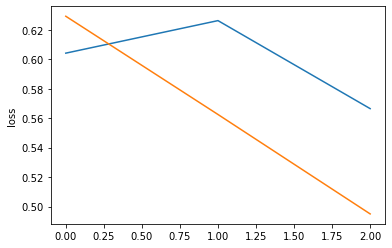

  time: 87s (wall 87s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.06e-01
  accuracy_average = 9.42e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.26e-01
  accuracy_average = 9.06e-01


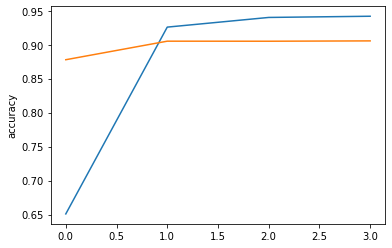

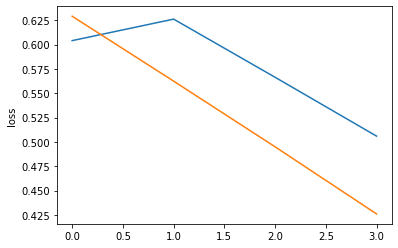

  time: 116s (wall 116s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.46e-01
  accuracy_average = 9.43e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.61e-01
  accuracy_average = 9.06e-01


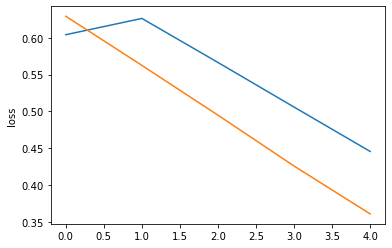

  time: 145s (wall 145s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 3.91e-01
  accuracy_average = 9.44e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.05e-01
  accuracy_average = 9.06e-01


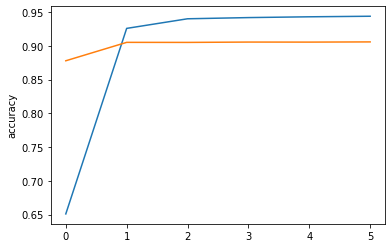

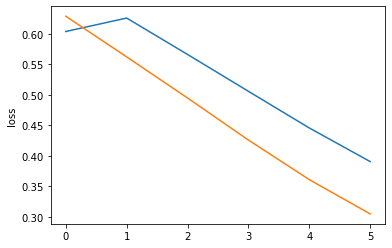

  time: 175s (wall 175s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 3.42e-01
  accuracy_average = 9.45e-01
  learning_rate = 9.90e-05, Validation_loss_average = 2.57e-01
  accuracy_average = 9.06e-01


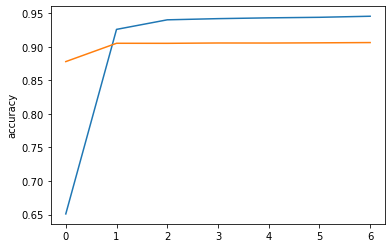

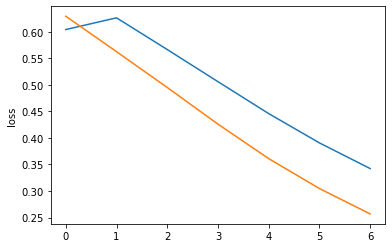

  time: 203s (wall 203s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.02e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.19e-01
  accuracy_average = 9.06e-01


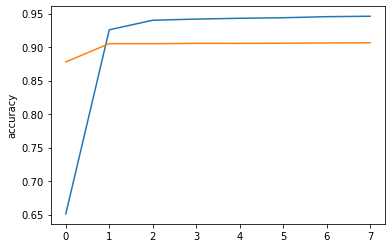

  time: 233s (wall 233s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.71e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.90e-01
  accuracy_average = 9.06e-01


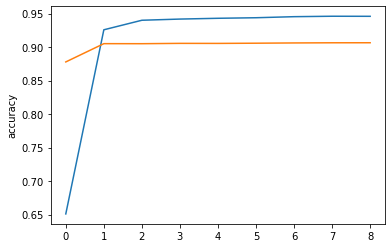

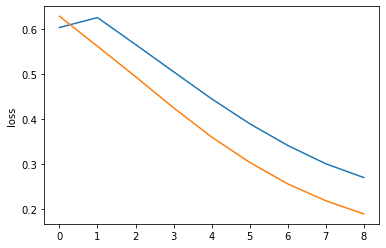

  time: 262s (wall 262s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.46e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.68e-01
  accuracy_average = 9.06e-01


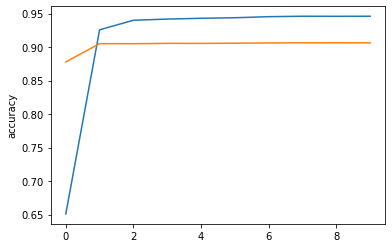

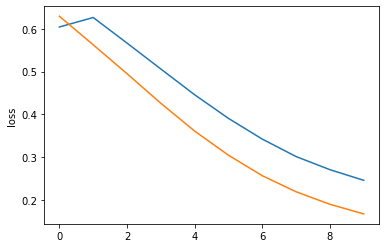

  time: 290s (wall 290s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.27e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.50e-01
  accuracy_average = 9.06e-01


  time: 318s (wall 318s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.13e-01
  accuracy_average = 9.46e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.37e-01
  accuracy_average = 9.06e-01


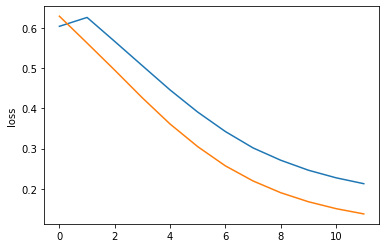

  time: 347s (wall 347s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.03e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.27e-01
  accuracy_average = 9.06e-01


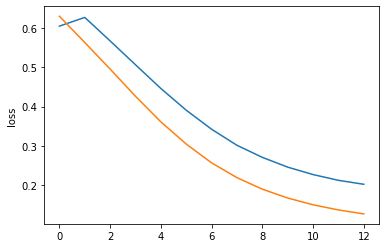

  time: 377s (wall 377s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.94e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.19e-01
  accuracy_average = 9.06e-01


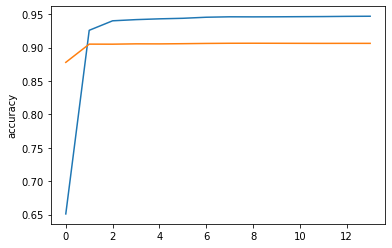

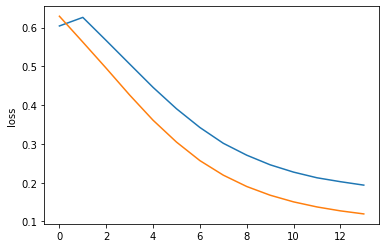

  time: 406s (wall 406s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 1.87e-01
  accuracy_average = 9.47e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.13e-01
  accuracy_average = 9.06e-01


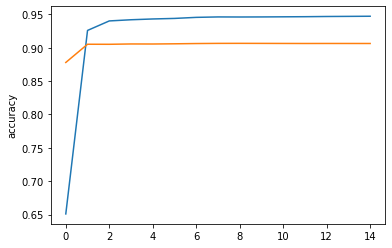

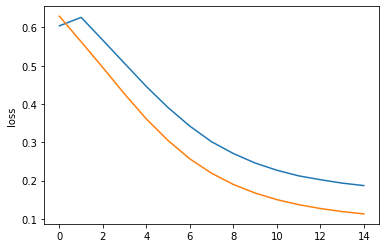

  time: 434s (wall 434s)
report_gnn:               precision    recall  f1-score   support

           0       0.97      0.76      0.85   2904206
           1       0.84      0.98      0.90   3700894

    accuracy                           0.88   6605100
   macro avg       0.91      0.87      0.88   6605100
weighted avg       0.90      0.88      0.88   6605100

ave_accuracy_gnn 0.8837368094351334
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

257/257 [==============================] - 8s 31ms/step - loss: 0.0816 - accuracy: 0.9769 - val_loss: 0.1740 - val_accuracy: 0.9408
Epoch 47/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0778 - accuracy: 0.9770 - val_loss: 0.1732 - val_accuracy: 0.9418
Epoch 48/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0843 - accuracy: 0.9766 - val_loss: 0.1729 - val_accuracy: 0.9422
Epoch 49/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0762 - accuracy: 0.9772 - val_loss: 0.1732 - val_accuracy: 0.9422
Epoch 50/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0848 - accuracy: 0.9760 - val_loss: 0.1720 - val_accuracy: 0.9425

Epoch 00050: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
Epoch 51/70
257/257 [==============================] - 8s 31ms/step - loss: 0.0775 - accuracy: 0.9773 - val_loss: 0.1726 - val_accuracy: 0.9423
Epoch 52/70
257/257 [==============================] - 8s 31ms/step 

No handles with labels found to put in legend.



Epoch 00070: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.


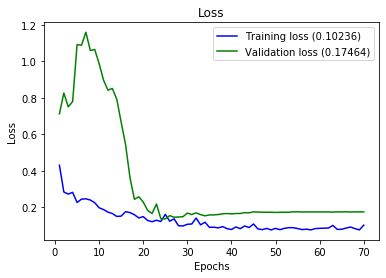

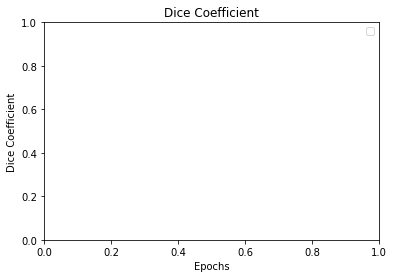

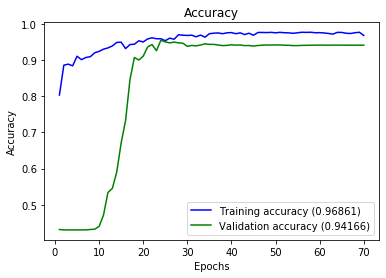

10
report_unet               precision    recall  f1-score   support

           0       0.97      0.81      0.88   2904206
           1       0.87      0.98      0.92   3700894

    accuracy                           0.90   6605100
   macro avg       0.92      0.89      0.90   6605100
weighted avg       0.91      0.90      0.90   6605100

accuracy_unet 0.9034549060574405
NN architecture
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0", dtype=int64), values=Tensor("inputs/Placeholder_2:0", dtype=float32), dense_shape=Tensor("inputs/Placeholder_1:0", dtype=int64)) 32 2
SparseTensor(indices=Tensor("inputs/Placeholder:0",

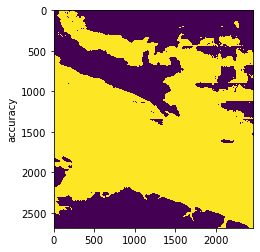

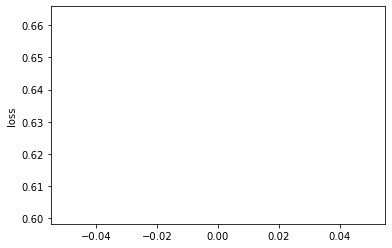

  time: 30s (wall 30s)
step 140 / 1050 (epoch 20.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.47e-01
  accuracy_average = 9.27e-01
  learning_rate = 1.00e-04, Validation_loss_average = 6.11e-01
  accuracy_average = 9.05e-01


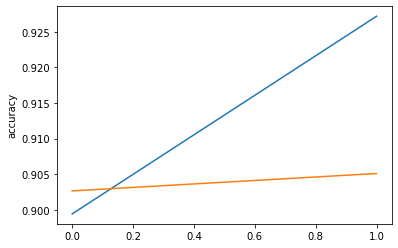

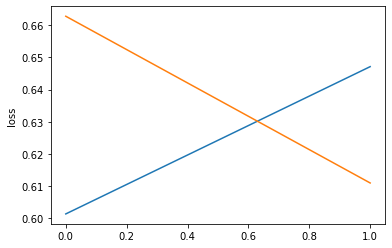

  time: 60s (wall 60s)
step 210 / 1050 (epoch 30.00 / 150):
  learning_rate = 1.00e-04, loss_average = 6.00e-01
  accuracy_average = 9.34e-01
  learning_rate = 1.00e-04, Validation_loss_average = 5.59e-01
  accuracy_average = 9.15e-01


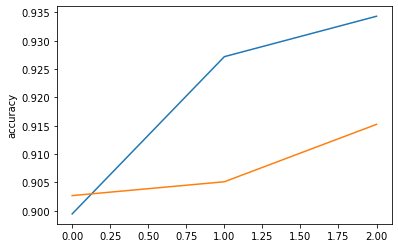

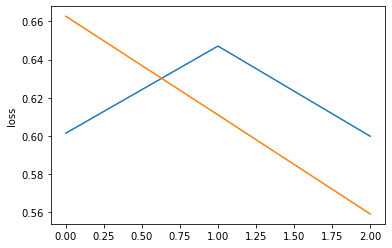

  time: 87s (wall 87s)
step 280 / 1050 (epoch 40.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.52e-01
  accuracy_average = 9.48e-01
  learning_rate = 9.90e-05, Validation_loss_average = 5.04e-01
  accuracy_average = 9.25e-01


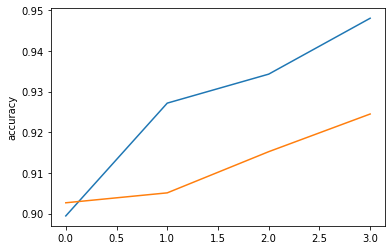

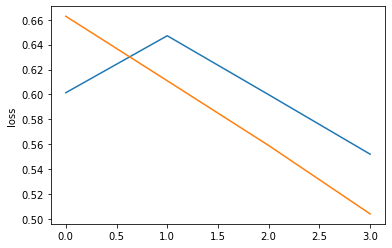

  time: 116s (wall 116s)
step 350 / 1050 (epoch 50.00 / 150):
  learning_rate = 9.90e-05, loss_average = 5.03e-01
  accuracy_average = 9.51e-01
  learning_rate = 9.90e-05, Validation_loss_average = 4.47e-01
  accuracy_average = 9.25e-01


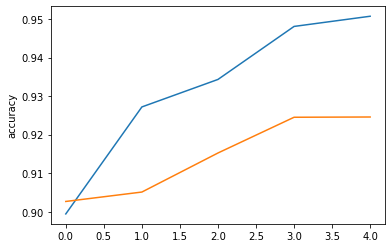

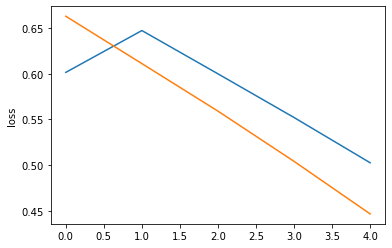

  time: 145s (wall 145s)
step 420 / 1050 (epoch 60.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.52e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.90e-01
  accuracy_average = 9.24e-01


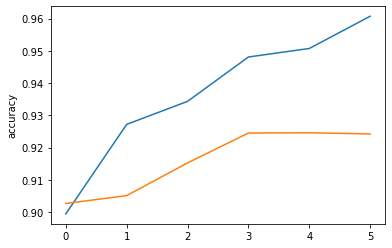

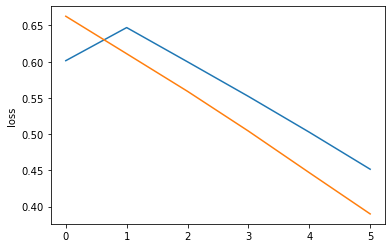

  time: 173s (wall 173s)
step 490 / 1050 (epoch 70.00 / 150):
  learning_rate = 9.90e-05, loss_average = 4.02e-01
  accuracy_average = 9.62e-01
  learning_rate = 9.90e-05, Validation_loss_average = 3.36e-01
  accuracy_average = 9.24e-01


  time: 202s (wall 202s)
step 560 / 1050 (epoch 80.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.54e-01
  accuracy_average = 9.59e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.86e-01
  accuracy_average = 9.23e-01


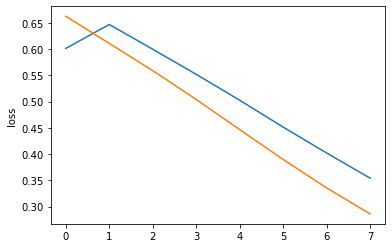

  time: 231s (wall 231s)
step 630 / 1050 (epoch 90.00 / 150):
  learning_rate = 9.80e-05, loss_average = 3.12e-01
  accuracy_average = 9.62e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.43e-01
  accuracy_average = 9.23e-01


  time: 262s (wall 262s)
step 700 / 1050 (epoch 100.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.76e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.80e-05, Validation_loss_average = 2.10e-01
  accuracy_average = 9.23e-01


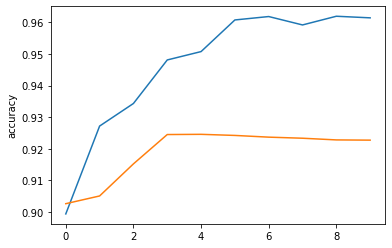

  time: 291s (wall 291s)
step 770 / 1050 (epoch 110.00 / 150):
  learning_rate = 9.80e-05, loss_average = 2.47e-01
  accuracy_average = 9.61e-01
  learning_rate = 9.80e-05, Validation_loss_average = 1.83e-01
  accuracy_average = 9.23e-01


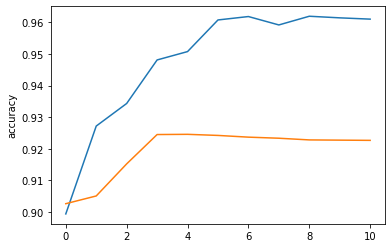

  time: 319s (wall 319s)
step 840 / 1050 (epoch 120.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.25e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.62e-01
  accuracy_average = 9.23e-01


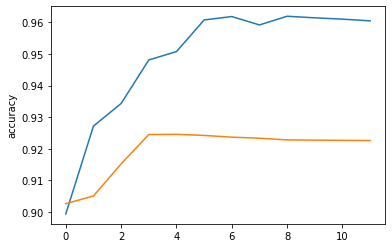

  time: 347s (wall 347s)
step 910 / 1050 (epoch 130.00 / 150):
  learning_rate = 9.70e-05, loss_average = 2.06e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.45e-01
  accuracy_average = 9.22e-01


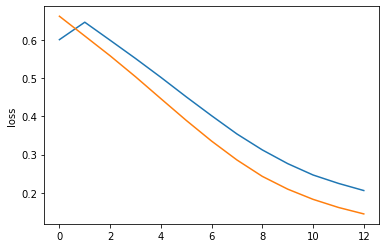

  time: 376s (wall 376s)
step 980 / 1050 (epoch 140.00 / 150):
  learning_rate = 9.70e-05, loss_average = 1.91e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.70e-05, Validation_loss_average = 1.31e-01
  accuracy_average = 9.22e-01


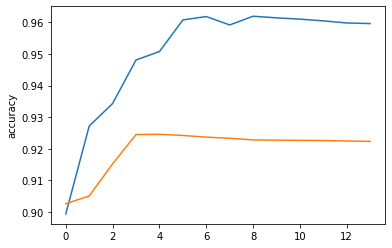

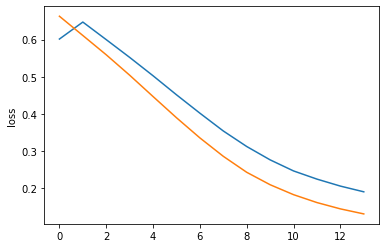

  time: 405s (wall 405s)
step 1050 / 1050 (epoch 150.00 / 150):
  learning_rate = 9.61e-05, loss_average = 1.79e-01
  accuracy_average = 9.60e-01
  learning_rate = 9.61e-05, Validation_loss_average = 1.20e-01
  accuracy_average = 9.22e-01


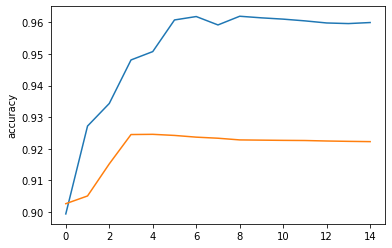

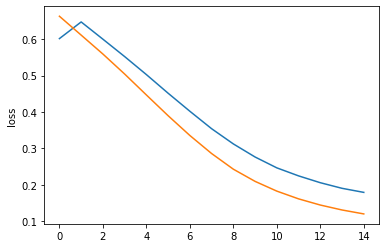

  time: 434s (wall 434s)
report_gnn:               precision    recall  f1-score   support

           0       0.97      0.80      0.88   2904206
           1       0.86      0.98      0.92   3700894

    accuracy                           0.90   6605100
   macro avg       0.92      0.89      0.90   6605100
weighted avg       0.91      0.90      0.90   6605100

ave_accuracy_gnn 0.9025796732827663
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 validation Data generation Complete
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 

No handles with labels found to put in legend.


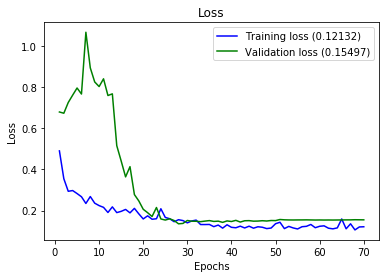

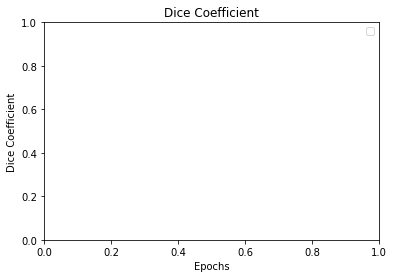

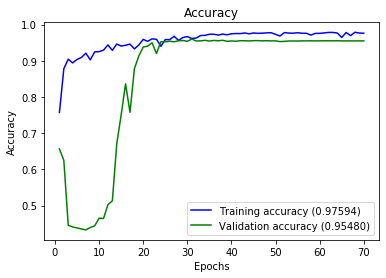

In [ ]:
iteration = 0
maxIteration = 10
while notConvergence and iteration < maxIteration:
    iteration = iteration + 1
    print(iteration)
    modelq = load_model('UnetElv.h5')
    test_predicted = np.zeros((valrow,valcol,2))
    test_groundtruth = np.zeros((valrow,valcol,2))
    tid = 0
    cstart = 0
    clength = 224
    rstart = 0
    rlength =224
    rend = rstart+rlength
    cend = cstart+clength
    fileid = 0
    stride = 224
    while True:
    #     X_test = np.load(testpath+str(fileid)+"testFeaturesWithElv.npy")
    #     X_test.shape = 1,224,224,4
        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]
        #a = findclass(test_groundtruth[rstart:rend,cstart:cend])
        #plt.imshow(a)

        fileid = fileid + 1
        #print("Firstfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        #update row and col pointers
        cstart = cstart+stride
        cend = cstart+clength
        if cend>test_predicted.shape[1]:
            cstart =0
            cend= clength
            rstart= rstart+stride
            rend = rstart+rlength
            if rend>test_predicted.shape[0]:
                break

    #bottom to up
    #if bottomUp:
    rend = test_predicted.shape[0]-1
    rstart = rend -rlength
    cstart = 0
    cend = clength
    while True:
        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]
        fileid = fileid + 1
        #print("Secondfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        #update row and col pointers
        cstart = cstart+stride
        cend = cstart+clength
        if cend>test_predicted.shape[1]:
            break 

    #if rightLeft:
    cend = test_predicted.shape[1]
    cstart = cend-clength
    rstart= 0
    rend = rstart+rlength
    while True:
        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]
        fileid = fileid + 1
        #print("Thirdfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        rstart=rstart+stride
        rend =rstart +rlength
        if rend>test_predicted.shape[0]:
            break

    #if bottomRightCorner:
    cend = test_predicted.shape[1]
    cstart = cend-clength
    rstart= test_predicted.shape[0]-rlength
    rend = test_predicted.shape[0]
    test = X_validation[fileid]
    test.shape = 1,224,224,4
    preds_test = modelq.predict(test)
    test_predicted[rstart:rend,cstart:cend] = preds_test
    test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]

    fileid = fileid + 1
    #print("Lastfileid= ",fileid, end= " ")
    preds_test = np.array(preds_test)
    preds_test.shape = 224,224,2
    test_predicted[rstart:rend,cstart:cend] = preds_test


    val_predict = test_predicted
    val_gt = test_groundtruth
    gt = findclass(val_gt)
    pr = findclass(val_predict)

    test_predicted = np.zeros((test1row,test1col,2))
    test_groundtruth = np.zeros((test1row,test1col,2))
    X_validation = train_features[np.concatenate((val_idx,test_idx), axis=None)]
    Y_validation =train_labels[np.concatenate((val_idx,test_idx), axis=None)]
    testpath= "C:\\tflow2\\Scripts\\wenchong\\KDD20\\Test\\Data\\"
    tid = 0
    cstart = 0
    clength = 224
    rstart = 0
    rlength =224
    rend = rstart+rlength
    cend = cstart+clength
    fileid = 120
    stride =224
    while True:

        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]


        fileid = fileid + 1

        #print("Firstfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        #update row and col pointers
        cstart = cstart+stride
        cend = cstart+clength
        if cend>test_predicted.shape[1]:
            cstart =0
            cend= clength
            rstart= rstart+stride
            rend = rstart+rlength
            if rend>test_predicted.shape[0]:
                break

    #bottom to up
    #if bottomUp:
    rend = test_predicted.shape[0]-1
    rstart = rend -rlength
    cstart = 0
    cend = clength
    while True:
        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]

        fileid = fileid + 1
        #print("Secondfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        #update row and col pointers
        cstart = cstart+stride
        cend = cstart+clength
        if cend>test_predicted.shape[1]:
            break 

    #if rightLeft:
    cend = test_predicted.shape[1]
    cstart = cend-clength
    rstart= 0
    rend = rstart+rlength
    while True:
        test = X_validation[fileid]
        test.shape = 1,224,224,4
        preds_test = modelq.predict(test)
        test_predicted[rstart:rend,cstart:cend] = preds_test
        test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]

        fileid = fileid + 1
        #print("Thirdfileid= ",fileid, end= " ")
        preds_test = np.array(preds_test)
        preds_test.shape = 224,224,2
        test_predicted[rstart:rend,cstart:cend] = preds_test
        rstart=rstart+stride
        rend =rstart +rlength
        if rend>test_predicted.shape[0]:
            break

    #if bottomRightCorner:
    cend = test_predicted.shape[1]
    cstart = cend-clength
    rstart= test_predicted.shape[0]-rlength
    rend = test_predicted.shape[0]
    test = X_validation[fileid]
    test.shape = 1,224,224,4
    preds_test = modelq.predict(test)
    test_predicted[rstart:rend,cstart:cend] = preds_test
    test_groundtruth[rstart:rend,cstart:cend] = Y_validation[fileid]

    fileid = fileid + 1
    #print("Lastfileid= ",fileid, end= " ")
    preds_test = np.array(preds_test)
    preds_test.shape = 224,224,2
    test_predicted[rstart:rend,cstart:cend] = preds_test

    test1_predict = test_predicted
    test1_gt = test_groundtruth
    pr = findclass(test1_predict)
    gt = findclass(test1_gt)
    
    fig = plt.figure()
    plt.imshow(pr)
    loca = 'C:/tflow2/Scripts/wenchong/NIPS2020/prediction/unetPR_'+str(iteration)+'.pdf'
    fig.savefig(loca, dpi=fig.dpi)
    
    y_true2 = np.copy(gt)
    y_true2.shape = y_true2.shape[0]*y_true2.shape[1]
    y_pred2 = np.copy(pr)
    y_pred2.shape = y_pred2.shape[0]*y_pred2.shape[1]
    y_pred2 = np.array(y_pred2,dtype='uint8')
    y_true2 = np.array(y_true2,dtype='uint8')
    confusion_matrix(y_true2, y_pred2, labels=[0, 1])

    report_unet = classification_report(y_true2, y_pred2)

    ave_accuracy_unet = accuracy_score(y_true2, y_pred2)
    print("report_unet", report_unet)
    print("accuracy_unet", ave_accuracy_unet)
    #np.savetxt

    #Train q on graph

    n_train = train_features.shape[0]
    params['decay_steps']    = n_train / params['batch_size']
    modelp = tpml.gnn(**params)

    train_labels_colgraph = []
    for i in range(train_labels_graph.shape[0]):
        temp = np.array(sparse.csr_matrix(DS[i]).dot(sparse.csr_matrix(train_labels_graph[i])).todense())
        temp[temp>=0.5] = 1
        temp[temp<0.5] = 0
        train_labels_colgraph.append(temp)
    train_labels_colgraph = np.array(train_labels_colgraph)

    labels_predict_colgraph = []
    for i in range(TrainCount):
        labels_predict_colgraph.append(train_labels_colgraph[i])

    val_predict.shape = val_predict.shape[0]*val_predict.shape[1], 2
    test1_predict.shape = test1_predict.shape[0]*test1_predict.shape[1], 2

    valtemp = np.array(sparse.csr_matrix(DS[TrainCount]).dot(sparse.csr_matrix(val_predict)).todense())
    valtemp[valtemp>=0.5] = 1
    valtemp[valtemp<0.5] = 0
    labels_predict_colgraph.append(valtemp)


    testtemp = np.array(sparse.csr_matrix(DS[TrainCount+1]).dot(sparse.csr_matrix(test1_predict)).todense())
    testtemp[testtemp>=0.5] = 1
    testtemp[testtemp<0.5] = 0
    labels_predict_colgraph.append(testtemp)

    labels_predict_colgraph =np.array(labels_predict_colgraph)

    true_labels_graph = train_labels_colgraph
    true_labels_graph = np.array(true_labels_graph)
    train_data = labels_predict_colgraph
    train_idx = range(TrainCount)
    valtest=np.array([TrainCount,TrainCount+1])

    predict = modelp.fit(train_data, labels_predict_colgraph,  true_labels_graph, train_idx, valtest,L1,L2)

    predict[0].shape = predict[0].shape[1],predict[0].shape[2]
    predict[1].shape = predict[1].shape[1], predict[1].shape[2]

    valtemp = np.array(sparse.csr_matrix(US[TrainCount]).dot(sparse.csr_matrix(predict[0])).todense())
    valtemp[valtemp>=0.5] = 1
    valtemp[valtemp<0.5] = 0
    valpred =np.reshape(valtemp, (valrow, valcol, 2))

    testtemp = np.array(sparse.csr_matrix(US[TrainCount+1]).dot(sparse.csr_matrix(predict[1])).todense())
    testtemp[testtemp>=0.5] = 1
    testtemp[testtemp<0.5] = 0
    test1pred = np.reshape(testtemp,  (test1row, test1col, 2))

    pred = findclass(test1pred)

    y_true3 = np.copy(gt)
    y_true3.shape = y_true3.shape[0]*y_true3.shape[1]
    y_pred3 = np.copy(pred)
    y_pred3.shape = y_pred3.shape[0]*y_pred3.shape[1]
    y_pred3 = np.array(y_pred3,dtype='uint8')
    y_true3 = np.array(y_true3,dtype='uint8')
    confusion_matrix(y_true3, y_pred3, labels=[0, 1])

    report_gnn = classification_report(y_true3, y_pred3)
    ave_accuracy_gnn = accuracy_score(y_true3, y_pred3)
    print("report_gnn:", report_gnn)
    print("ave_accuracy_gnn", ave_accuracy_gnn)

    if np.absolute(ave_accuracy_gnn - ave_accuracy_old) < threshold:
        notConvergence  = 0   

    ###Annotate val/test region label

    valimgpred = DataGenerator(valpred,filecounter = 0, filetype="validation",
                         stride=224,rlength=224, clength=224,cstart= 0,rstart = 0, bottomUp= True,rightLeft=True,bottomRightCorner=True)
    test1imgpred = DataGenerator(test1pred,filecounter = 0, filetype="test1",
                         stride=224,rlength=224, clength=224,cstart= 0,rstart = 0, bottomUp= True,rightLeft=True,bottomRightCorner=True)
    labels_predicted= np.concatenate((valimgpred,test1imgpred), axis = 0)

    labels_predict_graph_new = labels_predicted
    labels_predict_graph_new = np.concatenate((train_labels[range(TrainCount)], labels_predict_graph_new), axis=0 )

    ### Train U-net again

    X_train = train_features
    Y_train = labels_predict_graph_new
    X_validation = train_features[val_idx]
    Y_validation =train_labels[val_idx]

    modelqnew = UNET()
    learning_rate =0.0001
    patience = 70
    modelqnew.compile(optimizer=Adam(lr=learning_rate),loss ='categorical_crossentropy',metrics=['accuracy'])
    callbacks = [
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9, min_delta=0.00001, verbose=1, mode='min'),
            EarlyStopping(monitor='val_loss', patience=patience, verbose=0),
            ModelCheckpoint('UnetElv.h5', monitor='val_loss', save_best_only=True, verbose=0),
        ]

    results = modelqnew.fit(X_train , Y_train,validation_data=(X_validation,Y_validation), batch_size=10, epochs=70,
                       callbacks=callbacks)
    
    location = "unetTR_"+str(iteration)+".pdf"
    plot_history(results,location)